# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Data Preprocessing**

In [ ]:
# generic libraries

import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings("ignore")

# ML specific libraries

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer, confusion_matrix, plot_confusion_matrix
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# one minute tick data
# take ~4 minutes to run to parse dates - be patient!

zfile = zipfile.ZipFile('/content/drive/MyDrive/datasets/1_min_SPY_2008-2021.zip')
zfile.extractall()
tick_data = pd.read_csv("1_min_SPY_2008-2021.csv", parse_dates=['date'], cache_dates=True).drop(columns="Unnamed: 0")
tick_data

,date,open,high,low,close,volume,barCount,average
0,2009-05-22 07:30:00,89.45,89.46,89.37,89.37,7872,2102,89.424
1,2009-05-22 07:31:00,89.38,89.53,89.37,89.50,5336,1938,89.468
2,2009-05-22 07:32:00,89.51,89.54,89.48,89.49,3349,1184,89.516
3,2009-05-22 07:33:00,89.49,89.49,89.31,89.34,3495,1240,89.386
4,2009-05-22 07:34:00,89.33,89.46,89.33,89.39,9731,2637,89.379
...,...,...,...,...,...,...,...,...
2070829,2010-12-22 13:55:00,125.73,125.73,125.71,125.71,1876,677,125.714
2070830,2010-12-22 13:56:00,125.71,125.74,125.71,125.74,4769,1011,125.724
2070831,2010-12-22 13:57:00,125.74,125.74,125.73,125.74,2602,588,125.738
2070832,2010-12-22 13:58:00,125.74,125.82,125.73,125.81,22953,2866,125.776


In [ ]:
tick_data.dtypes

date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
barCount             int64
average            float64
dtype: object

In [ ]:
tick_data['Date'] = tick_data['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
cols = ['date','Date','open','high','low','close','volume','barCount','average']
tick_data = tick_data.sort_values(by='date', ascending=True).reset_index(drop=True)[cols]
tick_data

,date,Date,open,high,low,close,volume,barCount,average
0,2008-01-22 07:30:00,2008-01-22,126.45,126.82,126.00,126.67,30987,4541,126.283
1,2008-01-22 07:31:00,2008-01-22,126.67,127.17,126.39,127.12,20111,3125,126.958
2,2008-01-22 07:32:00,2008-01-22,127.10,127.13,126.71,126.78,11979,2074,126.922
3,2008-01-22 07:33:00,2008-01-22,126.76,126.90,126.53,126.54,8017,1350,126.675
4,2008-01-22 07:34:00,2008-01-22,126.54,127.18,126.54,126.78,11967,1253,126.730
...,...,...,...,...,...,...,...,...,...
2070829,2021-05-06 13:55:00,2021-05-06,418.56,418.77,418.48,418.49,9073,4584,418.660
2070830,2021-05-06 13:56:00,2021-05-06,418.50,418.73,418.47,418.64,6680,3095,418.622
2070831,2021-05-06 13:57:00,2021-05-06,418.64,418.79,418.63,418.79,6912,2868,418.744
2070832,2021-05-06 13:58:00,2021-05-06,418.79,418.83,418.71,418.76,7891,3862,418.784


In [ ]:
# get start and end dates for weekly dates

start_date = pd.to_datetime(tick_data['Date'].sort_values(ascending=True).iloc[0])
end_date = pd.to_datetime(tick_data['Date'].sort_values(ascending=True).iloc[-1])
print(f"Start date: {start_date} and end date: {end_date}")

Start date: 2008-01-22 00:00:00 and end date: 2021-05-06 00:00:00


In [ ]:
business_month_end_dates = pd.date_range(start_date, end_date, freq="bm")

In [ ]:
# China composite index

china_index = pd.read_csv("/content/drive/MyDrive/datasets/000001.SS.csv")
china_index_returns = china_index.set_index('Date')['Adj Close'].pct_change().to_frame().rename(columns={'Adj Close':"SSE Composite Return"}).fillna(0)
china_index_returns

,SSE Composite Return
Date,
2008-01-22,0.000000
2008-01-23,0.031426
2008-01-24,0.003123
2008-01-25,0.009317
2008-01-28,-0.071906
...,...
2021-04-26,-0.009499
2021-04-27,0.000419
2021-04-28,0.004200


In [ ]:
# ADS index

ads_index = pd.read_excel("/content/drive/MyDrive/datasets/ADS_Index_Most_Current_Vintage.xlsx") \
            .rename(columns={"Unnamed: 0":'Date'})
ads_index['Date'] = pd.to_datetime(ads_index['Date'].apply(lambda x: x.replace(":","-")))
ads_index = ads_index.set_index('Date')
ads_index = ads_index[ads_index.index.isin(tick_data['Date'])]
ads_index

,ADS_Index
Date,
2008-01-22,-0.723470
2008-01-23,-0.737825
2008-01-24,-0.750757
2008-01-25,-0.762268
2008-01-28,-0.790995
...,...
2021-04-30,0.368254
2021-05-03,0.316099
2021-05-04,0.300719


In [ ]:
# Dividend history

div_hist = pd.read_excel("/content/drive/MyDrive/datasets/Dividend_History_SP500.xlsx", parse_dates=['Ex-Dividend Date']) \
            .set_index('Ex-Dividend Date').drop(columns=['Dividend Amount'])
div_hist['Indicator'] = 1
div_hist = div_hist[div_hist.index.isin(ads_index.index)].reindex(ads_index.index, fill_value=0)
div_hist

,Indicator
Date,
2008-01-22,0
2008-01-23,0
2008-01-24,0
2008-01-25,0
2008-01-28,0
...,...
2021-04-30,0
2021-05-03,0
2021-05-04,0


In [ ]:
# Treasury yields

treasury_yields = pd.read_csv("/content/drive/MyDrive/datasets/Treasury_yields.csv", parse_dates=['Date'])
treasury_yields = treasury_yields[['Date', ' Close']].set_index('Date').rename(columns={' Close':"Treasury_Yields"})
treasury_yields

,Treasury_Yields
Date,
2021-05-06,0.010
2021-05-05,0.013
2021-05-04,0.015
2021-05-03,0.015
2021-04-30,0.010
...,...
2008-01-28,2.118
2008-01-25,2.098
2008-01-24,2.098


In [ ]:
# Recession Indicator

rec_ind = pd.read_csv("/content/drive/MyDrive/datasets/USRECDM.csv", parse_dates=['DATE']).rename(columns={'DATE':'Date'})
rec_ind = rec_ind.set_index('Date')
rec_ind

,USRECDM
Date,
2008-01-22,1
2008-01-23,1
2008-01-24,1
2008-01-25,1
2008-01-26,1
...,...
2021-05-02,0
2021-05-03,0
2021-05-04,0


In [ ]:
# Uncertainity data

uncertain_data = pd.read_excel("/content/drive/MyDrive/datasets/US_Policy_Uncertainty_Data.xlsx", skipfooter=1)
uncertain_data['Day'] = 1
uncertain_data['Month_Date'] = pd.to_datetime(uncertain_data[['Year', 'Month', 'Day']], errors='coerce').apply(lambda x: x.strftime("%Y-%m"))
uncertain_data = uncertain_data.drop(columns=['Year', 'Month', 'Day'])[['Month_Date', 'Three_Component_Index', 'News_Based_Policy_Uncert_Index']]
uncertain_data

,Month_Date,Three_Component_Index,News_Based_Policy_Uncert_Index
0,1985-01,125.224739,103.748802
1,1985-02,99.020813,78.313202
2,1985-03,112.190506,100.761482
3,1985-04,102.811325,84.778870
4,1985-05,120.082726,98.053658
...,...,...,...
436,2021-05,147.015839,172.096191
437,2021-06,133.578857,149.131256
438,2021-07,152.910904,182.171417
439,2021-08,133.876297,157.300735


In [ ]:
# Taiwan index

taiwan_index = pd.read_csv("/content/drive/MyDrive/datasets/^TWII.csv")
taiwan_index_returns = taiwan_index.set_index('Date')['Adj Close'].pct_change().to_frame().rename(columns={'Adj Close':"TAIEX MktCap Return"}).fillna(0)
taiwan_index_returns

,TAIEX MktCap Return
Date,
2008-01-22,0.000000
2008-01-23,-0.022891
2008-01-24,0.014666
2008-01-25,0.029605
2008-01-28,-0.032792
...,...
2021-04-28,-0.001612
2021-04-29,-0.000049
2021-05-03,-0.019600


In [ ]:
# VIX

vix = pd.read_csv("/content/drive/MyDrive/datasets/^VIX.csv")
vix = vix.set_index('Date')['Adj Close'].to_frame().rename(columns={'Adj Close':"VIX"})
vix

,VIX
Date,
2008-01-22,31.010000
2008-01-23,29.020000
2008-01-24,27.780001
2008-01-25,29.080000
2008-01-28,27.780001
...,...
2021-04-29,17.610001
2021-04-30,18.610001
2021-05-03,18.309999


# **Data Analysis**

In [ ]:
# compute returns

ret_cols = ['date','Date','close']
data_returns = tick_data[ret_cols]#.set_index('date')
data_returns['ret'] = data_returns['close'].pct_change()
data_returns

,date,Date,close,ret
0,2008-01-22 07:30:00,2008-01-22,126.67,NaN
1,2008-01-22 07:31:00,2008-01-22,127.12,0.003553
2,2008-01-22 07:32:00,2008-01-22,126.78,-0.002675
3,2008-01-22 07:33:00,2008-01-22,126.54,-0.001893
4,2008-01-22 07:34:00,2008-01-22,126.78,0.001897
...,...,...,...,...
2070829,2021-05-06 13:55:00,2021-05-06,418.49,-0.000167
2070830,2021-05-06 13:56:00,2021-05-06,418.64,0.000358
2070831,2021-05-06 13:57:00,2021-05-06,418.79,0.000358
2070832,2021-05-06 13:58:00,2021-05-06,418.76,-0.000072


In [ ]:
# compute daily volatility from the S&P 500 tick data

daily_std = data_returns.groupby('Date')['ret'].std().to_frame().rename(columns={'ret':'daily_vol'})
daily_std

,daily_vol
Date,
2008-01-22,0.001293
2008-01-23,0.001896
2008-01-24,0.000898
2008-01-25,0.000544
2008-01-28,0.000731
...,...
2021-04-30,0.000239
2021-05-03,0.000335
2021-05-04,0.000460


In [ ]:
data_returns['Date'] = pd.to_datetime(data_returns['Date'])
data_returns.dtypes

date     datetime64[ns]
Date     datetime64[ns]
close           float64
ret             float64
dtype: object

In [ ]:
# compute weekly volatility from the S&P 500 tick data

daily_ret = data_returns[['Date','ret']].groupby('Date')['ret'].apply(lambda x: (1+x).prod()-1).to_frame()
daily_ret = daily_ret.fillna(0)

weekly_std = pd.DataFrame(daily_ret.rolling(5).std(), index=daily_ret.index).rename(columns={'ret':'rolling_weekly_vol'})
# # weekly_std = data_returns.set_index('date').resample('W')['ret'].std().to_frame().rename(columns={'ret':'weekly_vol'})
weekly_std.head(10)

,rolling_weekly_vol
Date,
2008-01-22,NaN
2008-01-23,NaN
2008-01-24,NaN
2008-01-25,NaN
2008-01-28,0.017698
2008-01-29,0.014656
2008-01-30,0.012093
2008-01-31,0.014170
2008-02-01,0.010919


#### 1. ADS Index

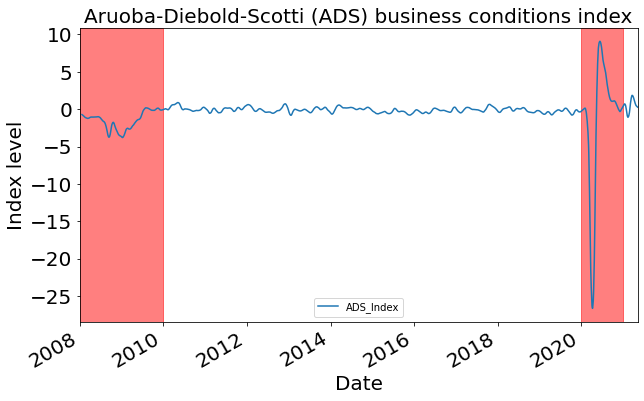

In [ ]:
ads_index.plot(figsize=(10,6))
plt.title("Aruoba-Diebold-Scotti (ADS) business conditions index", fontsize = 20)
plt.axvspan("2008", "2010", color='red', alpha=0.5);
plt.axvspan("2020", "2021", color='red', alpha=0.5);
plt.margins(x=0)
plt.xlabel("Date", fontsize = 20)
plt.ylabel('Index level', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('ads.png',dpi=1000)

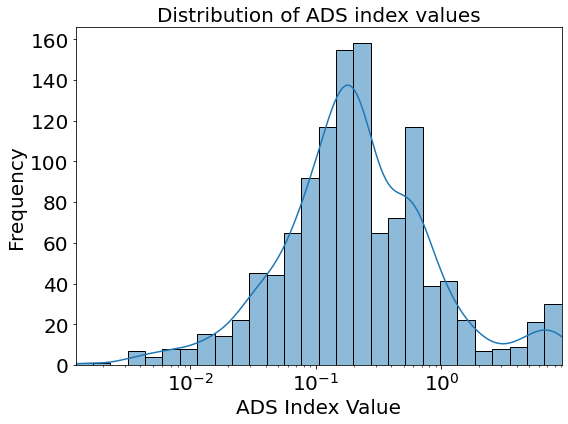

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.histplot(data = ads_index, x = "ADS_Index", kde=True, log_scale=True)
ax.margins(x = 0)
ax.set_ylabel("Frequency", fontsize = 20)
ax.set_xlabel("ADS Index Value", fontsize = 20)
ax.set_title("Distribution of ADS index values", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()
plt.savefig('ads_dist.png',dpi=1000)

#### 2. US Recession Indicator (NBER)

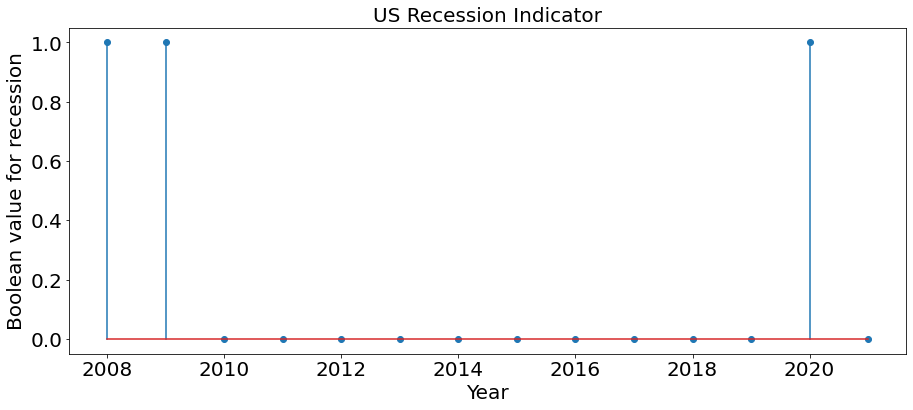

In [ ]:
rec_ind['Year'] = rec_ind.index.year
rec_ind_heatmap = rec_ind.groupby('Year')['USRECDM'].max().to_frame()
x = list(rec_ind_heatmap.USRECDM)
y = list(rec_ind_heatmap.index)
fig, ax = plt.subplots(figsize = (15,6))
plt.stem(y,x)
plt.title('US Recession Indicator', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Boolean value for recession', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('us_rec.png',dpi=1000)

#### 3. Dividend History

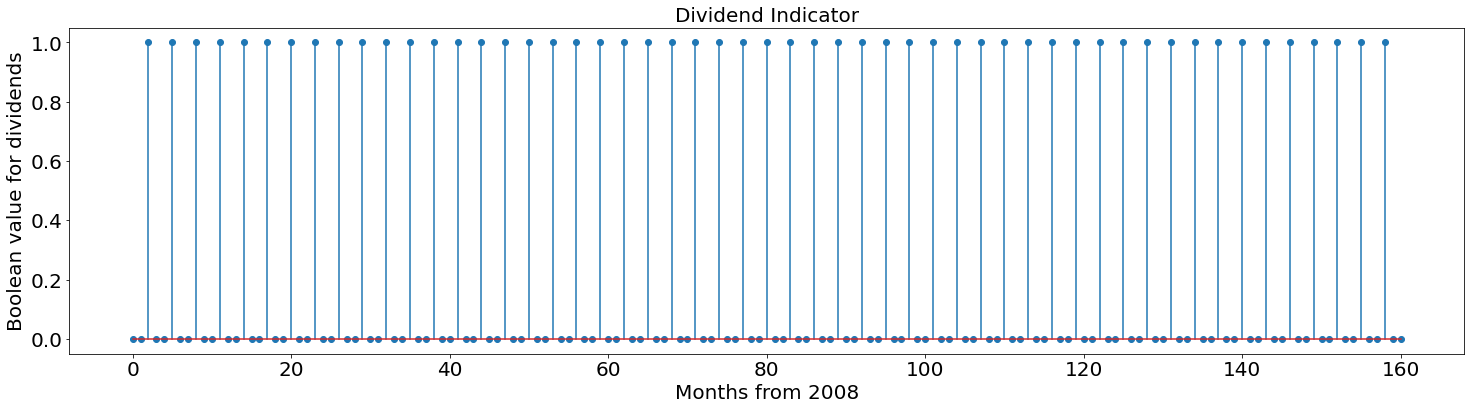

In [ ]:
div_hist['month_year'] = div_hist.index.to_period('M')
div_hist_heatmap = div_hist.groupby('month_year')['Indicator'].max().to_frame()
x = list(div_hist_heatmap.Indicator)
y = list(div_hist_heatmap.index.astype(str))

fig, ax = plt.subplots(figsize = (25,6))
plt.stem(x)
plt.title('Dividend Indicator', fontsize = 20)
plt.xlabel('Months from 2008', fontsize = 20)
plt.ylabel('Boolean value for dividends', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('div_ind.png',dpi=1000)

#### 4. China SSE Composite Index vs Taiwan Stock Index

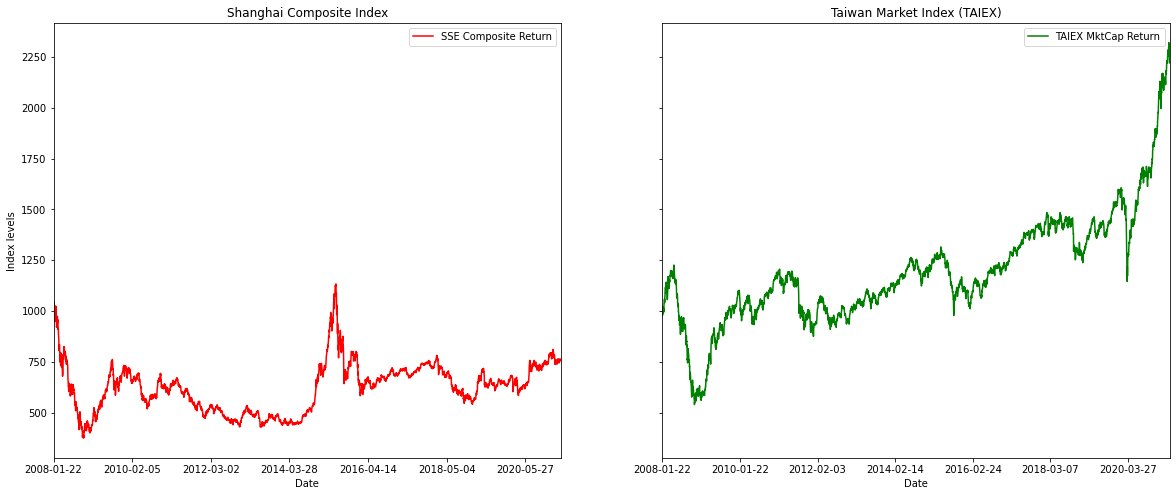

In [ ]:
china_index_rebased = (1 + china_index_returns).cumprod() * 1000
taiwan_index_rebased = (1 + taiwan_index_returns).cumprod() * 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=True)
china_index_rebased.plot(color='red', ax=ax1, title="Shanghai Composite Index");
ax1.set_ylabel('Index levels')
ax1.margins(x=0)
taiwan_index_rebased.plot(color='green', ax=ax2, title="Taiwan Market Index (TAIEX)");
ax2.set_ylabel('Index levels')
ax2.margins(x=0)

plt.savefig('china_taiwan_index.png',dpi=1000)

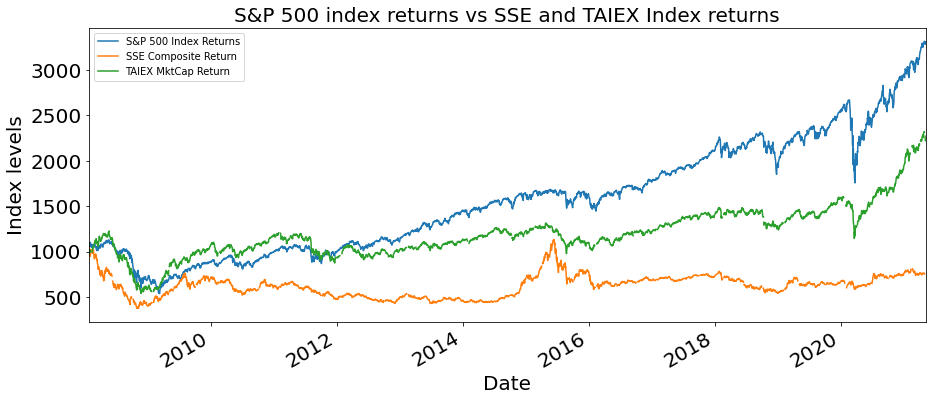

In [ ]:
us_index_rebased = (1 + daily_ret).cumprod() * 1000
ret_plot_compare = us_index_rebased.join(china_index_rebased).join(taiwan_index_rebased).rename(columns={'ret':'S&P 500 Index Returns'})

ret_plot_compare.plot(figsize=(15,6))
plt.ylabel('Index levels', fontsize = 20)
plt.title('S&P 500 index returns vs SSE and TAIEX Index returns', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.margins(x=0)

plt.savefig('compare_index.png',dpi=1000)

Gaps are seen in the time series of TAIEX, SSE index and S&P 500. This has be explained because the trading days in US are different from China and Taiwan. We have backfilled these dates because in absence of price levels we are assuming that the return is 0 so the price level remains the same as the last day.

In [ ]:
# Compare S&P 500 index vs China and Taiwan
ret_plot_compare = us_index_rebased.join(china_index_rebased).join(taiwan_index_rebased).rename(columns={'ret':'S&P 500 Index Returns'})
ret_plot_compare['SSE Composite Return'] = ret_plot_compare['SSE Composite Return'].fillna(method='ffill')
ret_plot_compare['TAIEX MktCap Return'] = ret_plot_compare['TAIEX MktCap Return'].fillna(method='ffill')
ret_plot_compare['SSE Composite Return'].iloc[0] = 1000
ret_plot_compare['TAIEX MktCap Return'].iloc[0] = 1000
ret_plot_compare

,S&P 500 Index Returns,SSE Composite Return,TAIEX MktCap Return
Date,,,
2008-01-22,1031.262335,1000.000000,1000.000000
2008-01-23,1057.472172,1031.426255,977.108855
2008-01-24,1065.129865,1034.647267,991.438900
2008-01-25,1050.367096,1044.286851,1020.790202
2008-01-28,1067.498224,969.196337,987.316036
...,...,...,...
2021-04-30,3294.386990,755.931656,2316.911062
2021-05-03,3301.255230,755.931656,2271.499076
2021-05-04,3281.361017,755.931656,2233.438811


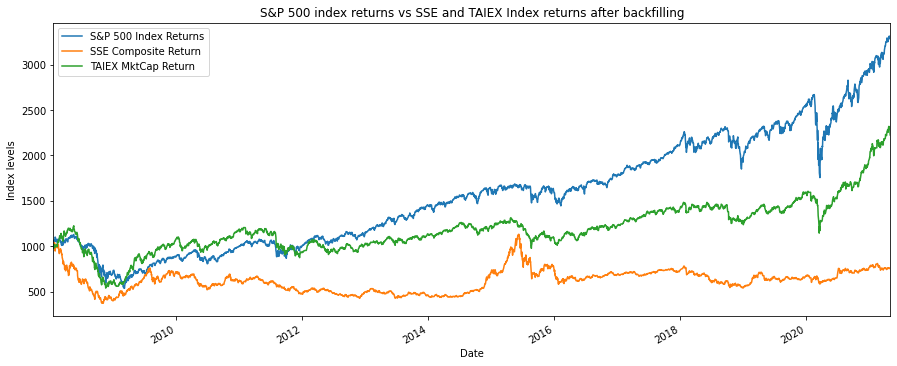

In [ ]:
ret_plot_compare.plot(figsize=(15,6))
plt.ylabel('Index levels')
plt.title('S&P 500 index returns vs SSE and TAIEX Index returns after backfilling')
plt.margins(x=0)
plt.savefig('compare_index_no_gaps.png',dpi=1000)

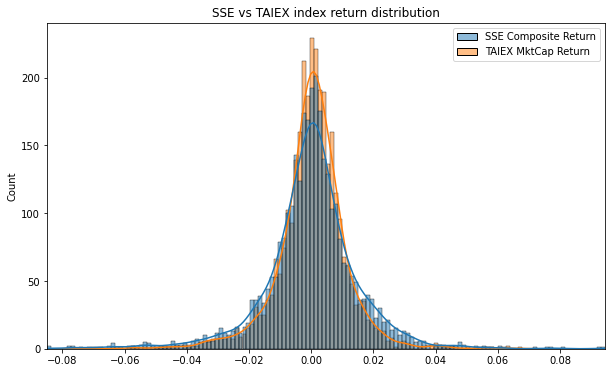

In [ ]:
supply_chain_df = china_index_returns.join(taiwan_index_returns)

fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data = supply_chain_df, kde=True)
ax.margins(x = 0)
ax.set_title("SSE vs TAIEX index return distribution")
plt.savefig('index_dist.png',dpi=1000)

#### 5. VIX

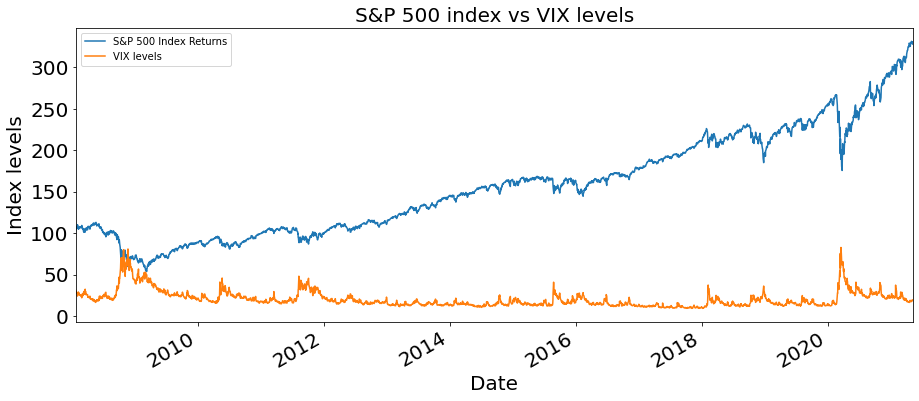

In [ ]:
#VIX and SP500 returns plot
vix_compare=vix
us_index_rebased = (1 + daily_ret).cumprod() * 100
vix_plot_compare = us_index_rebased.join(vix_compare['VIX']).rename(columns={'ret':'S&P 500 Index Returns','VIX':'VIX levels'})

vix_plot_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs VIX levels',fontsize = 20)
plt.ylabel('Index levels',fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.margins(x=0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('snp_vix.png',dpi=1000)

#### 6. Volume

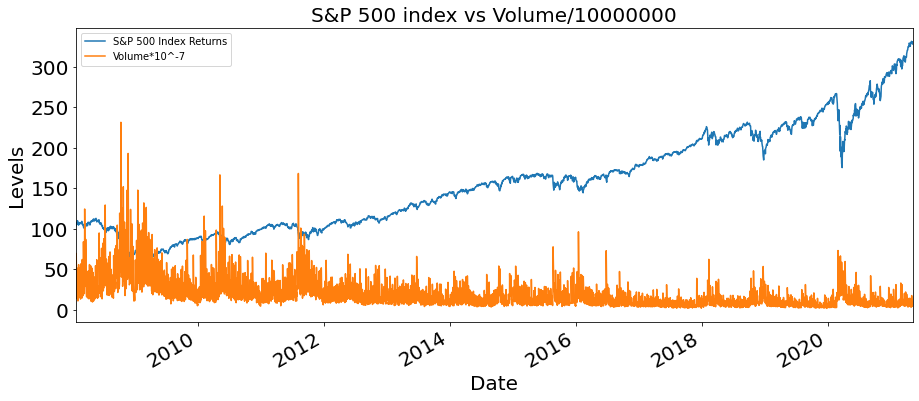

In [ ]:
daily_vol = tick_data.groupby('Date').sum()['volume'].to_frame()

us_index_rebased = (1 + daily_ret).cumprod() * 100
daily_vol_compare = us_index_rebased.join(daily_vol['volume']/100000).rename(columns={'ret':'S&P 500 Index Returns','volume':'Volume*10^-7'})

daily_vol_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs Volume/10000000',fontsize = 20)
plt.ylabel('Levels',fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.margins(x=0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('snp_vol.png',dpi=1000)

#### 7. Treasury yields

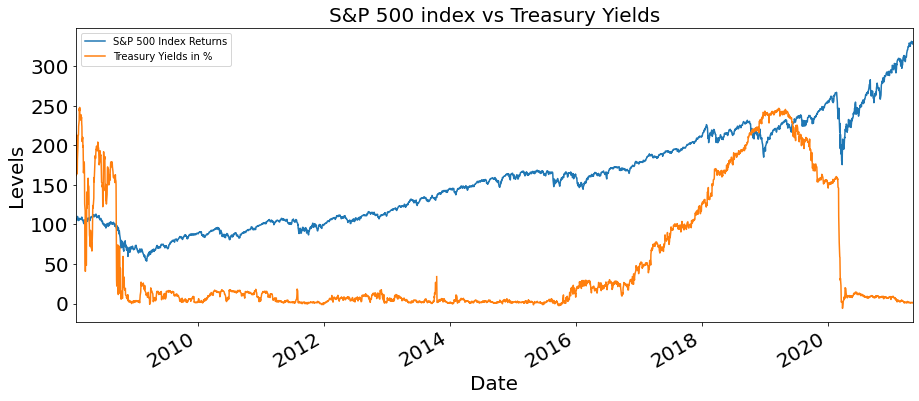

In [ ]:
treasury_compare=treasury_yields

us_index_rebased = (1 + daily_ret).cumprod() * 100
treasury_compare = us_index_rebased.join(treasury_compare['Treasury_Yields']*100).rename(columns={'ret':'S&P 500 Index Returns','Treasury_Yields':'Treasury Yields in %'})

treasury_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs Treasury Yields', fontsize = 20)
plt.ylabel('Levels',fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.margins(x=0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('snp_treasury.png',dpi=1000)

We can clearly see that because of quantitative easing in 2020, teasury yields drop and the stock market starts rallying again. The same effect is seen from 2008 to 2016 as well.

#### 8. Uncertainity Data

In [ ]:
monthly_returns = us_index_rebased[us_index_rebased.index.isin(business_month_end_dates)].pct_change()*1000
monthly_returns.index = monthly_returns.index.strftime("%Y-%m")
monthly_returns

,ret
Date,
2008-01,NaN
2008-02,-25.782957
2008-03,-13.980263
2008-04,49.283494
2008-05,13.584797
...,...
2020-12,27.612329
2021-01,-13.194797
2021-02,29.178509


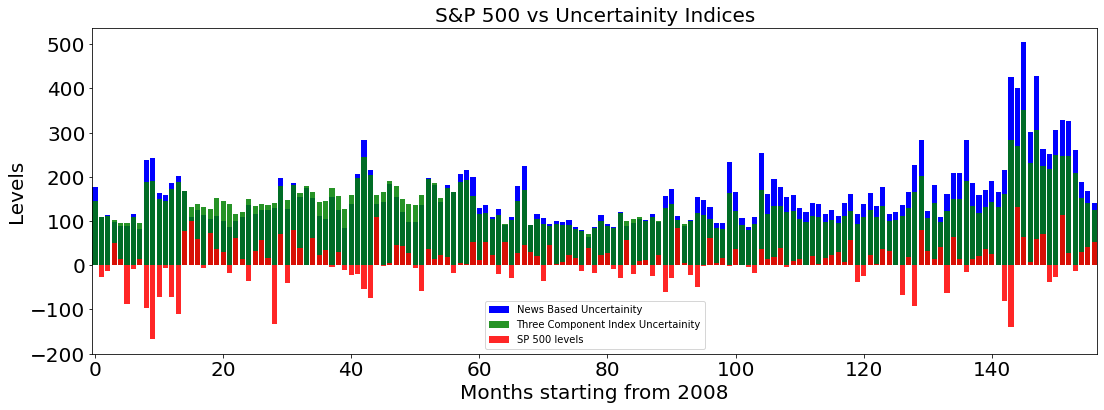

In [ ]:
uncertain_compare=uncertain_data
uncertain_compare=uncertain_compare.set_index('Month_Date')
uncertain_compare = monthly_returns.join(uncertain_compare).rename(columns={'ret':'S&P 500 Index Levels'})

width = 0.8

indices = np.arange(len(uncertain_compare['S&P 500 Index Levels']))
f, ax = plt.subplots(figsize=(18,6))
plt.bar(indices, uncertain_compare['News_Based_Policy_Uncert_Index'], width=width, color='b', label='News Based Uncertainity')
plt.bar(indices, uncertain_compare['Three_Component_Index'], width=width, color='g', alpha=0.85, label='Three Component Index Uncertainity')
plt.bar(indices, uncertain_compare['S&P 500 Index Levels'], width=width, color='r', alpha=0.85, label='SP 500 levels')
plt.xlabel('Months starting from 2008',fontsize = 20)
plt.ylabel('Levels',fontsize = 20)
plt.title('S&P 500 vs Uncertainity Indices',fontsize = 20)
plt.legend()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.margins(x=0)
plt.savefig('snp_uncertain.png',dpi=1000)

# **Linear Models**

In [ ]:
# Run linear regression with regularization terms - L1, L2 and maybe elastic net (not covered in class)
dependent_variable = daily_std

independent_variables = china_index_returns.join(taiwan_index_returns).join(ads_index).join(rec_ind) \
                                         .join(treasury_yields).join(div_hist).join(vix)

In [ ]:
data = dependent_variable.join(independent_variables)

In [ ]:
# fill missing values

data['month_date'] = data.index.strftime("%Y-%m")
data = pd.merge(data.reset_index(), uncertain_data, how='left', left_on="month_date", right_on="Month_Date").drop(columns=["month_date", "Month_Date"])
data.Date = pd.to_datetime(data.Date)
data = data.set_index("Date").drop(columns=['month_year','Year'])

cols = ['ADS_Index','SSE Composite Return','TAIEX MktCap Return','VIX','Treasury_Yields']
for col in cols:
    data[col] = data[col].fillna(method='ffill')

cols_2 = ['Indicator', 'USRECDM']
for col in cols_2:
    data[col] = data[col].fillna(0)

data

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index
Date,,,,,,,,,,
2008-01-22,0.001293,0.000000,0.000000,-0.723470,1.0,2.153,0.0,31.010000,144.984726,177.042206
2008-01-23,0.001896,0.031426,-0.022891,-0.737825,1.0,1.615,0.0,29.020000,144.984726,177.042206
2008-01-24,0.000898,0.003123,0.014666,-0.750757,1.0,2.098,0.0,27.780001,144.984726,177.042206
2008-01-25,0.000544,0.009317,0.029605,-0.762268,1.0,2.098,0.0,29.080000,144.984726,177.042206
2008-01-28,0.000731,-0.071906,-0.032792,-0.790995,1.0,2.118,0.0,27.780001,144.984726,177.042206
...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.000239,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,124.889526,141.300171
2021-05-03,0.000335,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,147.015839,172.096191
2021-05-04,0.000460,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,147.015839,172.096191


In [ ]:
data.describe()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index
count,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000
mean,0.000442,0.000157,0.000363,-0.397405,0.109949,0.518894,0.015238,20.177825,139.664200,156.808603
std,0.000391,0.015316,0.011231,2.587689,0.312873,0.753193,0.122515,9.903879,46.731769,70.803920
min,0.000049,-0.084909,-0.063125,-26.650400,0.000000,-0.061000,0.000000,9.140000,71.262146,63.877335
25%,0.000228,-0.006324,-0.004546,-0.442512,0.000000,0.033000,0.000000,13.630000,104.190811,108.396095
50%,0.000336,0.000664,0.000806,-0.148233,0.000000,0.104000,0.000000,17.280001,131.750702,137.859711
75%,0.000516,0.007294,0.005955,0.113641,0.000000,0.834500,0.000000,23.355001,162.629120,180.803543
max,0.006173,0.094551,0.067422,9.079900,1.000000,2.480000,1.000000,82.690002,350.459839,503.963348


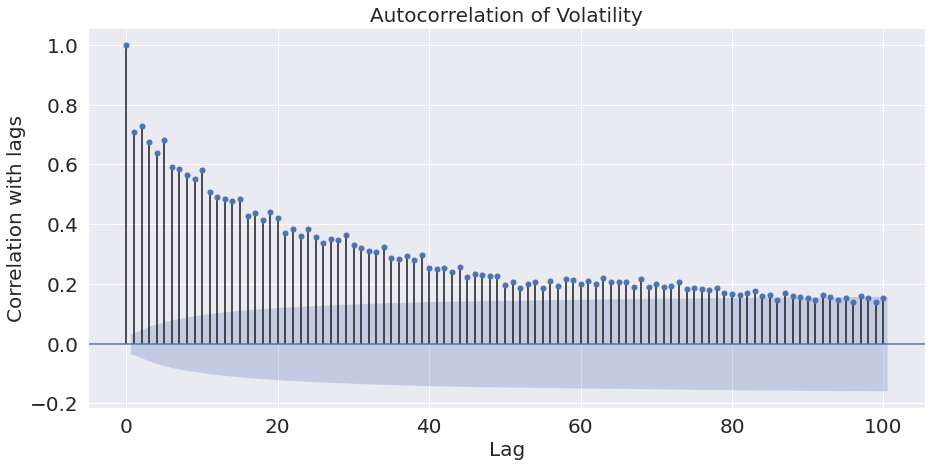

In [ ]:
# Computing mean and acf of the net returns
acf_daily_vol=pd.DataFrame(acf(data['daily_vol']),columns=['ACF values'])

# Plotting acf
N, M = 15, 7
fig, ax = plt.subplots(figsize=(N, M))
plot_acf((data['daily_vol']*1000).values,lags=100,ax=ax)
plt.title('Autocorrelation of Volatility',fontsize = 20)
ax.set_xlabel('Lag',fontsize = 20)
ax.set_ylabel('Correlation with lags',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('auto_corr.png',dpi=1000)

From the ACF graph, we can see correlation being the largest with 5 days (1 week) and 20 days (1 month) hence we will be taking those lag values for daily volatility

In [ ]:
# add lag variables

data['5_day_lag']=data['daily_vol'].shift(5)
data['20_day_lag']=data['daily_vol'].shift(20)
data = data.dropna()
data.head()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
Date,,,,,,,,,,,,
2008-02-20,0.000933,-0.020854,-0.016193,-1.11036,1.0,2.344,0.0,24.400000,108.104691,108.314735,0.000643,0.001293
2008-02-21,0.000638,-0.008725,0.024252,-1.11983,1.0,2.388,0.0,25.120001,108.104691,108.314735,0.000671,0.001896
2008-02-22,0.000387,-0.034656,0.002817,-1.12831,1.0,2.317,0.0,24.059999,108.104691,108.314735,0.000609,0.000898
2008-02-25,0.000716,-0.040673,0.021902,-1.14890,1.0,2.355,0.0,23.030001,108.104691,108.314735,0.000277,0.000544
2008-02-26,0.000581,0.010887,0.002578,-1.15557,1.0,2.268,0.0,21.900000,108.104691,108.314735,0.000768,0.000731


In [ ]:
# standardize and train test split

data_org = data.copy()

X = data.drop(columns=['daily_vol'])
Y = (data['daily_vol']*1000)

split = 0.8
n = X.shape[0]
X_train = X.iloc[:int(n*split),:]
X_test = X.iloc[int(n*split):,:]
y_train = Y.iloc[:int(n*split)]
y_test = Y.iloc[int(n*split):]

for i in range(X_train.shape[1]):
  mu = X_train.iloc[:,i].mean()
  std = X_train.iloc[:,i].std()
  X_train.iloc[:,i] = (X_train.iloc[:,i] - mu) / std
  X_test.iloc[:,i] = (X_test.iloc[:,i] - mu) / std
  print("Train:", round(X_train.iloc[:,i].mean(),1), round(X_train.iloc[:,i].std(),1))
  print("Test:", round(X_test.iloc[:,i].mean(),1), round(X_test.iloc[:,i].std(),1))

y_mu = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mu) / y_std
y_test = (y_test - y_mu) / y_std
print("yTrain:", round(y_train.mean(),1), round(y_train.std(),1))
print("yTest:", round(y_test.mean(),1), round(y_test.std(),1))

print()
print("Training data size:", X_train.shape, y_train.shape)
print("Testing data size:", X_test.shape, y_test.shape)

Train: 0.0 1.0
Test: 0.0 0.8
Train: 0.0 1.0
Test: 0.1 0.9
Train: 0.0 1.0
Test: -0.4 6.9
Train: -0.0 1.0
Test: -0.2 0.7
Train: 0.0 1.0
Test: 1.5 1.9
Train: 0.0 1.0
Test: 0.0 1.0
Train: -0.0 1.0
Test: 0.2 1.0
Train: 0.0 1.0
Test: 1.5 1.9
Train: 0.0 1.0
Test: 2.4 2.3
Train: 0.0 1.0
Test: 0.0 1.3
Train: 0.0 1.0
Test: -0.0 1.3
yTrain: 0.0 1.0
yTest: 0.0 1.3

Training data size: (2661, 11) (2661,)
Testing data size: (666, 11) (666,)


In [ ]:
data_org.head()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
Date,,,,,,,,,,,,
2008-02-20,0.000933,-0.020854,-0.016193,-1.11036,1.0,2.344,0.0,24.400000,108.104691,108.314735,0.000643,0.001293
2008-02-21,0.000638,-0.008725,0.024252,-1.11983,1.0,2.388,0.0,25.120001,108.104691,108.314735,0.000671,0.001896
2008-02-22,0.000387,-0.034656,0.002817,-1.12831,1.0,2.317,0.0,24.059999,108.104691,108.314735,0.000609,0.000898
2008-02-25,0.000716,-0.040673,0.021902,-1.14890,1.0,2.355,0.0,23.030001,108.104691,108.314735,0.000277,0.000544
2008-02-26,0.000581,0.010887,0.002578,-1.15557,1.0,2.268,0.0,21.900000,108.104691,108.314735,0.000768,0.000731


In [ ]:
data.head()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
Date,,,,,,,,,,,,
2008-02-20,0.000933,-0.020854,-0.016193,-1.11036,1.0,2.344,0.0,24.400000,108.104691,108.314735,0.000643,0.001293
2008-02-21,0.000638,-0.008725,0.024252,-1.11983,1.0,2.388,0.0,25.120001,108.104691,108.314735,0.000671,0.001896
2008-02-22,0.000387,-0.034656,0.002817,-1.12831,1.0,2.317,0.0,24.059999,108.104691,108.314735,0.000609,0.000898
2008-02-25,0.000716,-0.040673,0.021902,-1.14890,1.0,2.355,0.0,23.030001,108.104691,108.314735,0.000277,0.000544
2008-02-26,0.000581,0.010887,0.002578,-1.15557,1.0,2.268,0.0,21.900000,108.104691,108.314735,0.000768,0.000731


In [ ]:
# OLS

X_train = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     577.6
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:04:13   Log-Likelihood:                -2147.6
No. Observations:                2661   AIC:                             4319.
Df Residuals:                    2649   BIC:                             4390.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
def compute_plot_feature_importance(model, title, linear = False, X = X):
    if(linear == True):
      if(title == "OLS" or title == "Improved OLS"):
        feat_imp = abs(model.params[1:])
        feature_importance = pd.DataFrame(list(zip(X.columns.tolist(),feat_imp)), \
                                          columns=['feature_name', 'feature_importance']) \
                                  .sort_values('feature_importance', ascending = False) \
                                  .reset_index(drop=True)
      else:
        feat_imp = abs(model.coef_[1:])
        feature_importance = pd.DataFrame(list(zip(X.columns.tolist()[1:],feat_imp)), \
                                          columns=['feature_name', 'feature_importance']) \
                                  .sort_values('feature_importance', ascending = False) \
                                  .reset_index(drop=True)
    else:
      if title == "Control Burn":
          feat_imp = model.feature_importances_.tolist()
          feat_imp = feat_imp / np.sum(feat_imp)
      else:
          feat_imp = model.best_estimator_.feature_importances_.tolist()
          feat_imp = feat_imp / np.sum(feat_imp)

      feature_importance = pd.DataFrame(list(zip(X.columns.tolist(),feat_imp)), \
                                          columns=['feature_name', 'feature_importance']) \
                                  .sort_values('feature_importance', ascending = False) \
                                  .reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x = 'feature_importance',
                y = 'feature_name',
                data = feature_importance)
    plt.xlabel('Relative Importance of feature for regresssor',fontsize=20)
    plt.ylabel('Feature Name',fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

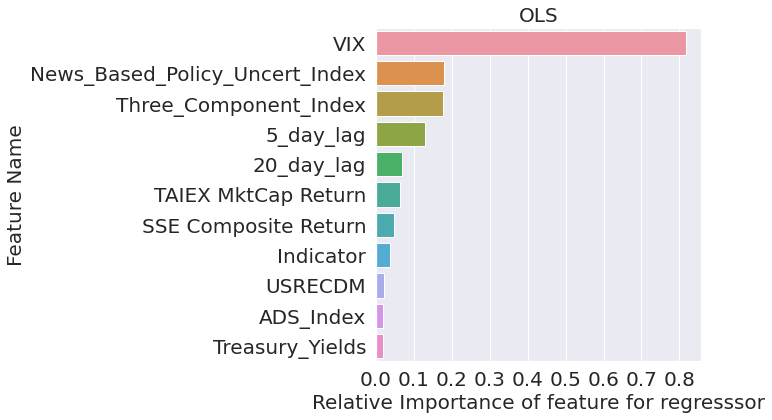

In [ ]:
compute_plot_feature_importance(res, "OLS", linear = True)

In [ ]:
# check collinearity

def high_corr(value):
    color = 'red' if value > 0.5 or value < -0.5 else 'black'
    return 'color: %s' % color

temp = data.drop(columns=['daily_vol'])
corr = temp.corr()
df=pd.DataFrame(corr)
corr_mat=df.style.applymap(high_corr)
corr_mat

,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
SSE Composite Return,1.000000,0.335298,0.005632,-0.033261,-0.035798,0.020260,-0.049441,0.001713,-0.004956,-0.033931,-0.000246
TAIEX MktCap Return,0.335298,1.000000,0.007627,-0.031958,-0.015181,0.042450,-0.077447,0.022805,0.011013,-0.022614,0.038296
ADS_Index,0.005632,0.007627,1.000000,-0.408454,-0.009846,-0.003775,-0.384770,-0.137644,-0.195050,-0.397438,-0.439350
USRECDM,-0.033261,-0.031958,-0.408454,1.000000,0.109891,0.004678,0.589372,0.070858,0.052288,0.500028,0.459176
Treasury_Yields,-0.035798,-0.015181,-0.009846,0.109891,1.000000,-0.003723,-0.204795,-0.162695,0.036559,-0.094730,-0.102064
Indicator,0.020260,0.042450,-0.003775,0.004678,-0.003723,1.000000,0.004332,0.009324,0.008941,-0.038548,0.010262
VIX,-0.049441,-0.077447,-0.384770,0.589372,-0.204795,0.004332,1.000000,0.511336,0.399477,0.739512,0.613827
Three_Component_Index,0.001713,0.022805,-0.137644,0.070858,-0.162695,0.009324,0.511336,1.000000,0.909407,0.297661,0.263564
News_Based_Policy_Uncert_Index,-0.004956,0.011013,-0.195050,0.052288,0.036559,0.008941,0.399477,0.909407,1.000000,0.251401,0.201822
5_day_lag,-0.033931,-0.022614,-0.397438,0.500028,-0.094730,-0.038548,0.739512,0.297661,0.251401,1.000000,0.485962


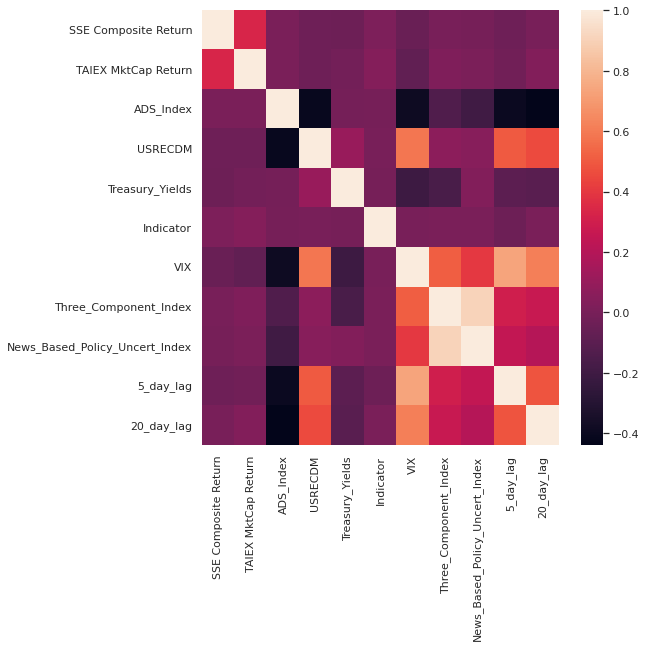

In [ ]:
# heatmap

sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)
plt.show()

In [ ]:
# remove collinear features

X_train = X_train.drop(columns=['News_Based_Policy_Uncert_Index','Three_Component_Index','USRECDM', 'ADS_Index'])
X_test = X_test.drop(columns=['News_Based_Policy_Uncert_Index','Three_Component_Index','USRECDM', 'ADS_Index'])

print("Training data size:", X_train.shape, y_train.shape)
print("Testing data size:", X_test.shape, y_test.shape)

X_train = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit()

print(res.summary())

Training data size: (2661, 8) (2661,)
Testing data size: (666, 7) (666,)
                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     866.9
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:04:14   Log-Likelihood:                -2191.9
No. Observations:                2661   AIC:                             4400.
Df Residuals:                    2653   BIC:                             4447.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

btscv = BlockingTimeSeriesSplit(n_splits=5)

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(
    estimator,
    X,
    y,
):

  train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X = X,
        y = y,
        scoring='neg_mean_squared_error',
        cv=btscv,
    )
  train_scores_mean = -np.mean(train_scores, axis=1)

  train_scores_std = np.std(train_scores, axis=1)

  test_scores_mean = -np.mean(test_scores, axis=1)

  test_scores_std = np.std(test_scores, axis=1)

  _, axes = plt.subplots(1, 1, figsize=(20, 5))
  axes.set_xlabel("Training examples", fontsize = 20)
  axes.set_ylabel("Score", fontsize = 20)
  plt.xticks(fontsize = 20)
  plt.yticks(fontsize = 20)

  axes.grid()
  axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
  axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
  axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
  axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
  axes.legend(loc="best", fontsize = 20)
  print(test_scores_mean[-1])
  print(train_scores_mean[-1])

In [ ]:
rid_reg = RidgeCV(alphas=np.arange(0, 1.1, 0.01), fit_intercept=True, cv=btscv).fit(X_train, y_train)
rid_reg.coef_


array([ 0.        , -0.04964643, -0.07114704,  0.04273572, -0.03594837,
        0.75455811,  0.15037278, -0.07472128])

Index(['const', 'SSE Composite Return', 'TAIEX MktCap Return',
       'Treasury_Yields', 'Indicator', 'VIX', '5_day_lag', '20_day_lag'],
      dtype='object')


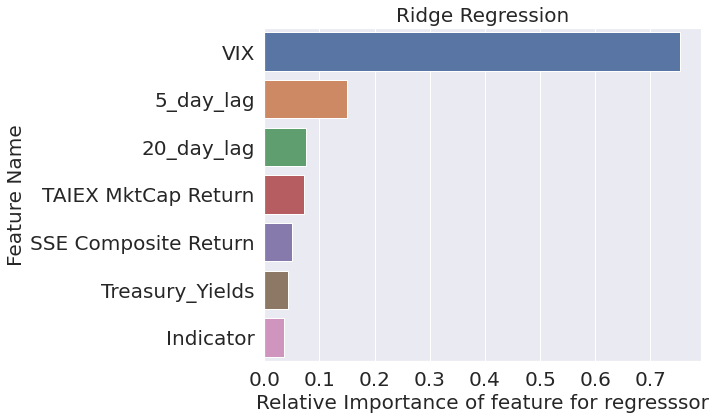

In [ ]:
print(X_train.columns)
compute_plot_feature_importance(rid_reg, "Ridge Regression", True, X_train)

0.10981760336212283
0.3319431871434492


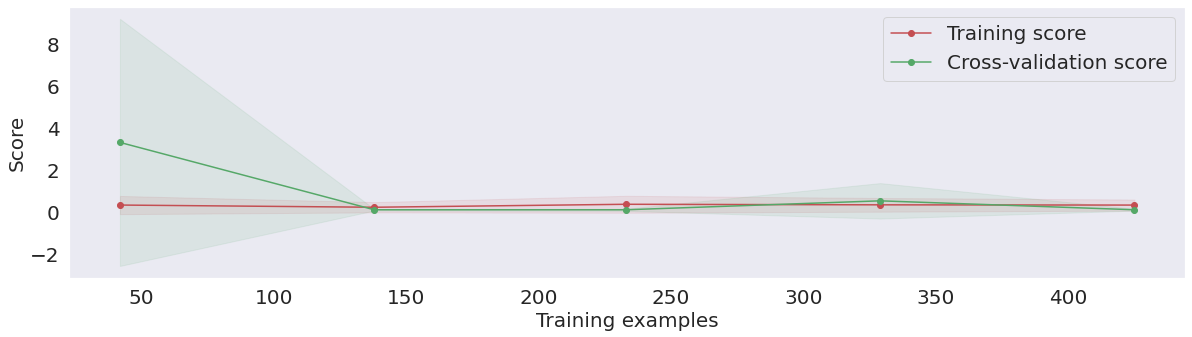

In [ ]:
plot_learning_curve(rid_reg, X_train, y_train)

In [ ]:
las_reg = LassoCV(alphas=np.arange(0, 1.1, 0.01), fit_intercept=True, cv=btscv).fit(X_train, y_train)
las_reg.coef_

array([ 0.        , -0.03670888, -0.06157037,  0.01939412, -0.01920944,
        0.69812666,  0.13600017, -0.00966952])

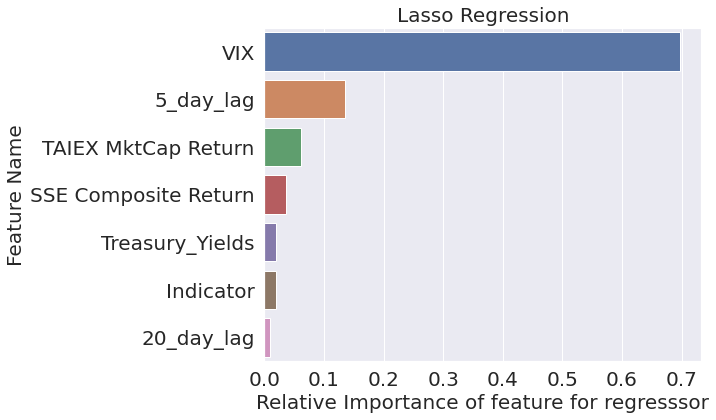

In [ ]:
compute_plot_feature_importance(las_reg, "Lasso Regression", True, X_train)

0.10315634123562764
0.3343193333686515


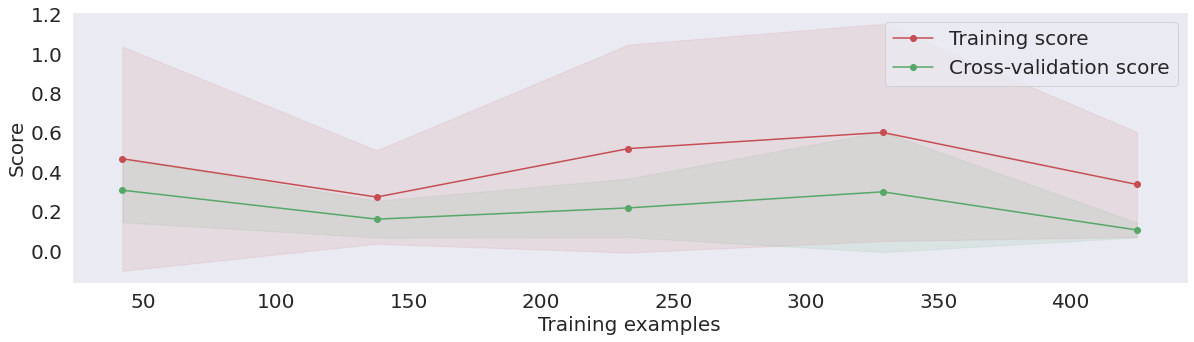

In [ ]:
plot_learning_curve(las_reg, X_train, y_train)

In [ ]:
ela_net = ElasticNetCV(alphas=np.arange(0, 1.1, 0.01), fit_intercept=True, cv=btscv).fit(X_train, y_train)
ela_net.coef_

array([ 0.        , -0.03671577, -0.06293876,  0.01620578, -0.01832426,
        0.6643881 ,  0.15307311, -0.        ])

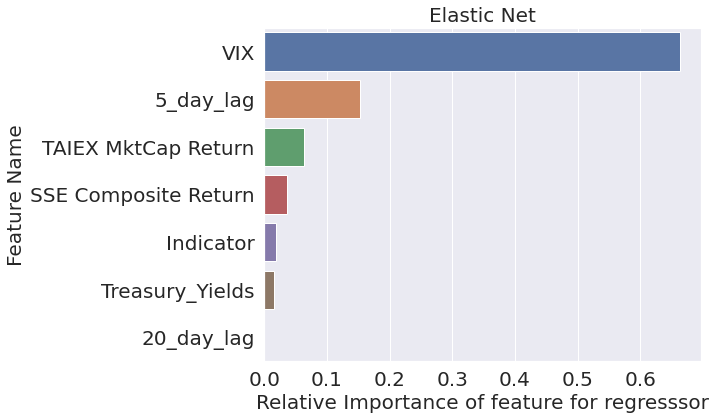

In [ ]:
compute_plot_feature_importance(ela_net, "Elastic Net", True, X_train)

0.1057401135408689
0.33283550707711956


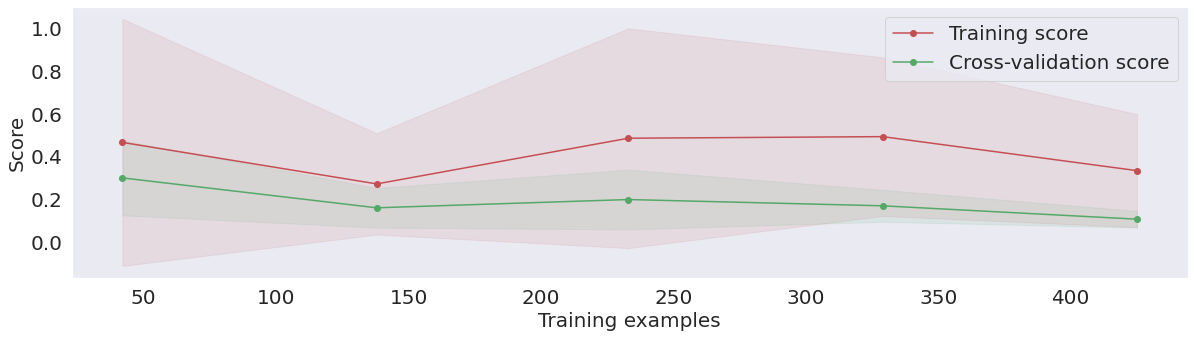

In [ ]:
plot_learning_curve(ela_net, X_train, y_train)

In [ ]:
def calculate_aic(n, mse, num_params):
	aic = n * np.log(mse) + 2 * num_params
	return aic

num_params = len(res.params)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Testing the co-efficients on the test data for OLS

y_pred=X_train.dot(res.params)
square_error_ols_train=(y_train-y_pred)**2
print('Train MSE for OLS =',square_error_ols_train.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(res.params)
y_ols=y_predict
square_error_ols_test=(y_test-y_predict)**2
print('Test MSE for OLS =',square_error_ols_test.mean())

aic_ols = calculate_aic(len(y_predict), square_error_ols_test.mean(), num_params)
print('AIC for OLS: %.3f' % aic_ols)

train_mae_ols = mean_absolute_error(y_train, y_pred)
print('Train MAE for OLS: %.3f' % train_mae_ols)

mae_ols = mean_absolute_error(y_test, y_predict)
print('Test MAE for OLS: %.3f' % mae_ols)

r2_ols = r2_score(y_test, y_predict)
print('R_2 for OLS: %.3f' % r2_ols)

Train MSE for OLS = 0.30408238232733215
Test MSE for OLS = 0.6806025932674323
AIC for OLS: -240.261
Train MAE for OLS: 0.337
Test MAE for OLS: 0.535
R_2 for OLS: 0.588


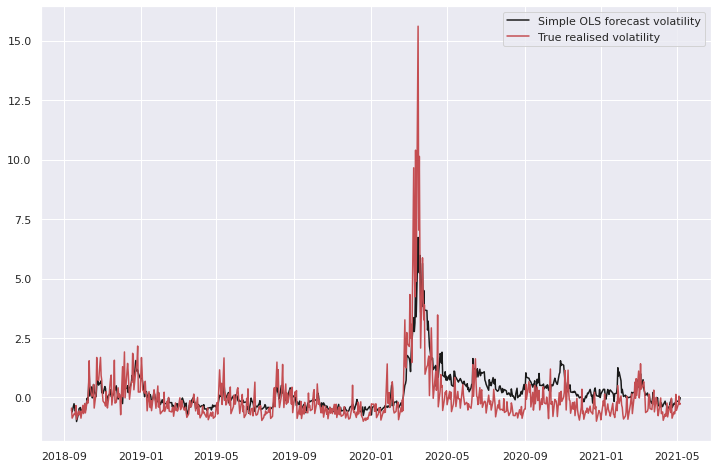

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_predict,label='Simple OLS forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

In [ ]:
# Testing the co-efficients on the test data for ridge

y_pred=X_train.dot(rid_reg.coef_)
square_error_ridge_train=(y_train-y_pred)**2
print('Train MSE for ridge =',square_error_ridge_train.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(rid_reg.coef_)
y_ridge=y_predict
square_error_ridge_test=(y_test-y_predict)**2
print('Test MSE for ridge =',square_error_ridge_test.mean())

aic_ridge = calculate_aic(len(y_predict), square_error_ridge_test.mean(), num_params)
print('AIC for ridge: %.3f' % aic_ridge)

train_mae_ridge = mean_absolute_error(y_train, y_pred)
print('Train MAE for ridge: %.3f' % train_mae_ridge)

mae_ridge = mean_absolute_error(y_test, y_predict)
print('Test MAE for ridge: %.3f' % mae_ridge)

r2_ridge = r2_score(y_test, y_predict)
print('R_2 for ridge: %.3f' % r2_ridge)

Train MSE for ridge = 0.30408267094499875
Test MSE for ridge = 0.6805218143337695
AIC for ridge: -240.340
Train MAE for ridge: 0.337
Test MAE for ridge: 0.535
R_2 for ridge: 0.589


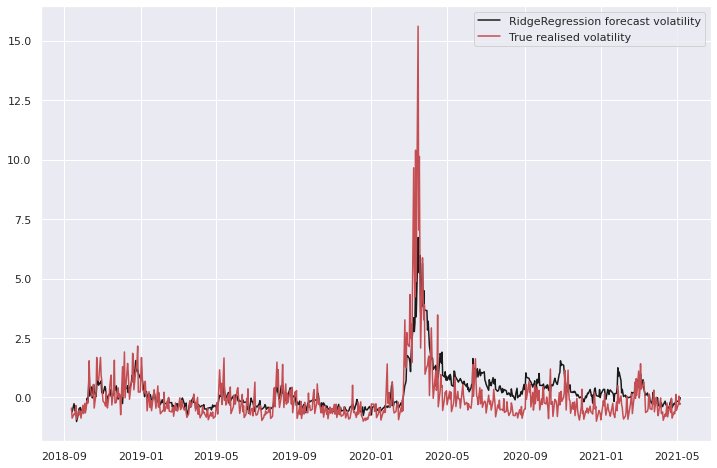

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_predict,label='RidgeRegression forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

In [ ]:
# Testing the co-efficients on the test data for lasso

y_pred=X_train.dot(las_reg.coef_)
square_error_las_train=(y_train-y_pred)**2
print('Train MSE for lasso =',square_error_las_train.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(las_reg.coef_)
y_lasso=y_predict
square_error_las_test=(y_test-y_predict)**2
print('Test MSE for lasso =',square_error_las_test.mean())

aic_las = calculate_aic(len(y_predict), square_error_las_test.mean(), num_params)
print('AIC for lasso: %.3f' % aic_las)

train_mae_las = mean_absolute_error(y_train, y_pred)
print('Train MAE for lasso: %.3f' % train_mae_las)

mae_las = mean_absolute_error(y_test, y_predict)
print('Test MAE for lasso: %.3f' % mae_las)

r2_las = r2_score(y_test, y_predict)
print('R_2 for lasso: %.3f' % r2_las)

Train MSE for lasso = 0.30807112573663525
Test MSE for lasso = 0.7158056878921296
AIC for lasso: -206.675
Train MAE for lasso: 0.335
Test MAE for lasso: 0.529
R_2 for lasso: 0.567


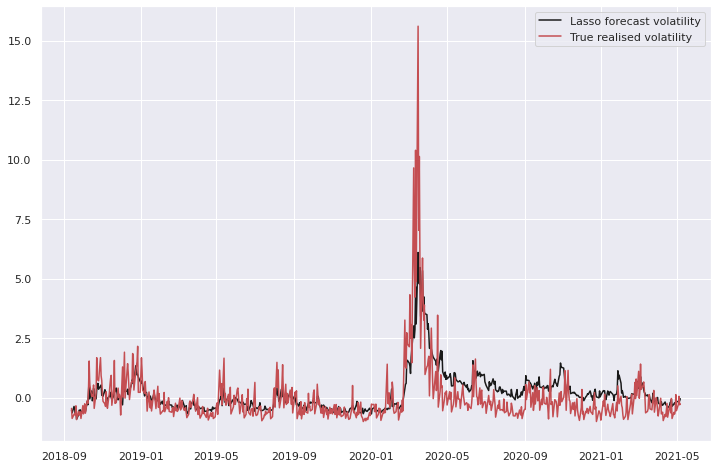

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_predict,label='Lasso forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

In [ ]:
# Testing the co-efficients on the test data for elasticNetCV

y_pred=X_train.dot(ela_net.coef_)
square_error_ela_train=(y_train-y_pred)**2
print('Train MSE for ElasticNet =',square_error_ela_train.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(ela_net.coef_)
y_en=y_predict
square_error_ela_test=(y_test-y_predict)**2
print('Test MSE for ElasticNet =',square_error_ela_test.mean())

aic_ela = calculate_aic(len(y_predict), square_error_ela_test.mean(), num_params)
print('AIC for ElasticNet: %.3f' % aic_ela)

train_mae_ela = mean_absolute_error(y_train, y_pred)
print('Train MAE for ElasticNet: %.3f' % train_mae_ela)

mae_ela = mean_absolute_error(y_test, y_predict)
print('Test MAE for ElasticNet: %.3f' % mae_ela)

r2_ela = r2_score(y_test, y_predict)
print('R_2 for ElasticNet: %.3f' % r2_ela)

Train MSE for ElasticNet = 0.30958782700327686
Test MSE for ElasticNet = 0.7148550285826418
AIC for ElasticNet: -207.560
Train MAE for ElasticNet: 0.335
Test MAE for ElasticNet: 0.522
R_2 for ElasticNet: 0.568


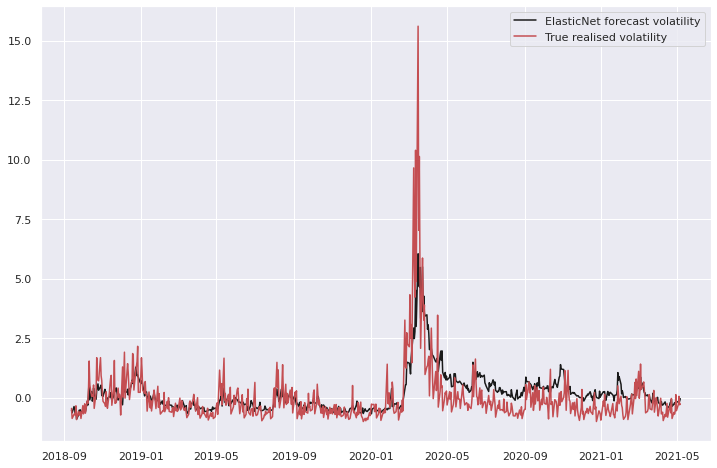

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_predict,label='ElasticNet forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

In [ ]:
results = {'OLS':[square_error_ols_train.mean(), square_error_ols_test.mean(), train_mae_ols, mae_ols, aic_ols, r2_ols], 
           'Ridge':[square_error_ridge_train.mean(), square_error_ridge_test.mean(), train_mae_ridge, mae_ridge, aic_ridge, r2_ridge],
           'Lasso':[square_error_las_train.mean(), square_error_las_test.mean(), train_mae_las, mae_las, aic_las, r2_las],
           'Elastic':[square_error_ela_train.mean(), square_error_ela_test.mean(), train_mae_ela, mae_ela, aic_ela, r2_ela]}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Train MSE","Test MSE","Train MAE","Test MAE","AIC","Test R_2 Score"]).T
results_df

,OLS,Ridge,Lasso,Elastic
Train MSE,0.304082,0.304083,0.308071,0.309588
Test MSE,0.680603,0.680522,0.715806,0.714855
Train MAE,0.337351,0.337307,0.335189,0.335060
Test MAE,0.535239,0.535043,0.528809,0.522380
AIC,-240.261287,-240.340337,-206.674792,-207.559892
Test R_2 Score,0.588468,0.588517,0.567182,0.567757


# **Linear Models Improvement**

In [ ]:
# Feature transformation
 
feature_new=data_org[['Three_Component_Index','News_Based_Policy_Uncert_Index']]
feature_new=feature_new.join(daily_vol['volume'])
feature_new.head()

,Three_Component_Index,News_Based_Policy_Uncert_Index,volume
Date,,,
2008-02-20,108.104691,108.314735,2009789
2008-02-21,108.104691,108.314735,1799178
2008-02-22,108.104691,108.314735,5693319
2008-02-25,108.104691,108.314735,1737135
2008-02-26,108.104691,108.314735,1799681


In [ ]:
feature = feature_new['volume']/(feature_new['News_Based_Policy_Uncert_Index']+feature_new['Three_Component_Index'])
feature.describe()

count     3327.000000
mean      6063.829501
std       6261.736067
min        472.930904
25%       2274.047306
50%       4142.863225
75%       7350.082017
max      61985.960317
dtype: float64

In [ ]:
feature = feature.to_frame()
feature.columns = ['volume_to_uncertainity']
feature.head()

,volume_to_uncertainity
Date,
2008-02-20,9286.546210
2008-02-21,8313.384956
2008-02-22,26306.875987
2008-02-25,8026.705515
2008-02-26,8315.709147


In [ ]:
# adding new feature

split = 0.8
n = feature.shape[0]

feature_train = feature.iloc[:int(n*split),:]
feature_test = feature.iloc[int(n*split):,:]

feature_mu = feature_train['volume_to_uncertainity'].mean()
feature_std = feature_train['volume_to_uncertainity'].std()
feature_train['volume_to_uncertainity'] = (feature_train['volume_to_uncertainity'] - feature_mu) / feature_std
feature_test['volume_to_uncertainity'] = (feature_test['volume_to_uncertainity'] - feature_mu) / feature_std

print("featureTrain:", round(feature_train['volume_to_uncertainity'].mean(),1), round(feature_train['volume_to_uncertainity'].std(),1))
print("featureTest:", round(feature_test['volume_to_uncertainity'].mean(),1), round(feature_test['volume_to_uncertainity'].std(),1))

X_train = X_train.join(feature_train)
X_test = X_test.join(feature_test)

X_train = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit()

print(res.summary())

featureTrain: 0.0 1.0
featureTest: -0.7 0.3
                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     805.5
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:13:36   Log-Likelihood:                -2135.4
No. Observations:                2661   AIC:                             4289.
Df Residuals:                    2652   BIC:                             4342.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

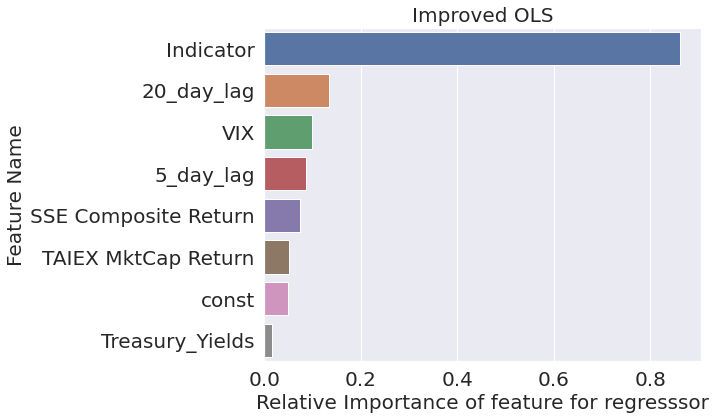

In [ ]:
compute_plot_feature_importance(res, "Improved OLS", True, X_train)

In [ ]:
# Testing the co-efficients on the test data for OLS

y_pred=res.predict(X_train)
square_error_ols_train=(y_train-y_pred)**2
print('Train MSE for OLS =',square_error_ols_train.mean())

X_test = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=res.predict(X_test)
y_improved=y_predict
square_error_ols_test=(y_test-y_predict)**2
print('Test MSE for OLS =',square_error_ols_test.mean())

aic_ols = calculate_aic(len(y_predict), square_error_ols_test.mean(), num_params)
print('AIC for OLS: %.3f' % aic_ols)

train_mae_ols = mean_absolute_error(y_train, y_pred)
print('Train MAE for OLS: %.3f' % train_mae_ols)

mae_ols = mean_absolute_error(y_test, y_predict)
print('Test MAE for OLS: %.3f' % mae_ols)

r2_ols = r2_score(y_test, y_predict)
print('R_2 for OLS: %.3f' % r2_ols)

Train MSE for OLS = 0.2914388289203249
Test MSE for OLS = 0.762634757574185
AIC for OLS: -164.470
Train MAE for OLS: 0.328
Test MAE for OLS: 0.609
R_2 for OLS: 0.539


In [ ]:
results = {'Improved OLS':[square_error_ols_train.mean(), square_error_ols_test.mean(), train_mae_ols, mae_ols, aic_ols, r2_ols]}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Train MSE","Test MSE","Train MAE","Test MAE","AIC","Test R_2 Score"]).T
results_df

,Improved OLS
Train MSE,0.291439
Test MSE,0.762635
Train MAE,0.328013
Test MAE,0.609475
AIC,-164.470053
Test R_2 Score,0.538866


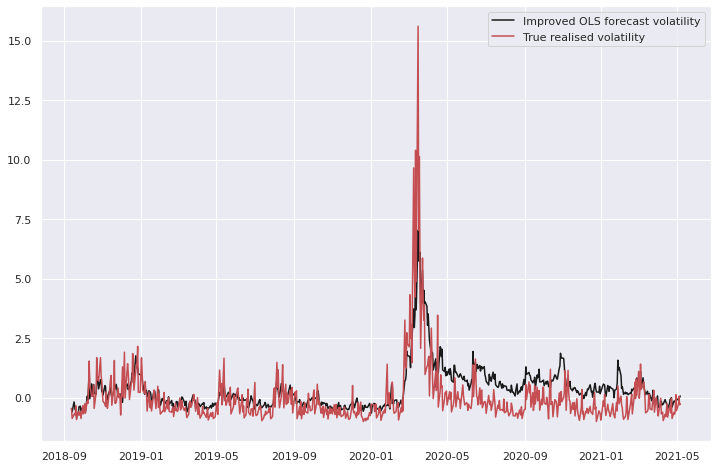

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_predict,label='Improved OLS forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

# **Time Regime Divison**

In [ ]:
X = X.drop(columns=['News_Based_Policy_Uncert_Index','Three_Component_Index','USRECDM', 'ADS_Index'])
X = X.join(feature)

for i in range(X.shape[1]):
  mu = X.iloc[:,i].mean()
  std = X.iloc[:,i].std()
  X.iloc[:,i] = (X.iloc[:,i] - mu) / std
  print(round(X.iloc[:,i].mean(),1), round(X.iloc[:,i].std(),1))

y_mu = Y.mean()
y_std = Y.std()
Y = (Y - y_mu) / y_std
print(round(Y.mean(),1), round(Y.std(),1))

X = sm.add_constant(X)

-0.0 1.0
-0.0 1.0
-0.0 1.0
-0.0 1.0
-0.0 1.0
-0.0 1.0
0.0 1.0
-0.0 1.0
0.0 1.0


In [ ]:
# Regime 1 : Jan 2008 to Dec 2010

reg1_X = X.loc['2008-02-20':'2010-12-31']
reg1_y = Y.loc['2008-02-20':'2010-12-31']

mod1 = sm.OLS(reg1_y, reg1_X)
res1 = mod1.fit()

print(res1.summary())
print()

y1 = reg1_X.dot(res1.params)
err1 = (reg1_y - y1)**2
print('Train MSE for Regime 1 =', err1.mean())

                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     192.9
Date:                Fri, 03 Dec 2021   Prob (F-statistic):          6.74e-173
Time:                        20:14:27   Log-Likelihood:                -800.08
No. Observations:                 724   AIC:                             1618.
Df Residuals:                     715   BIC:                             1659.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

In [ ]:
# Regime 2 : Jan 2011 to Dec 2019

reg2_X = X.loc['2011-01-01':'2019-12-31']
reg2_y = Y.loc['2011-01-01':'2019-12-31']

mod2 = sm.OLS(reg2_y, reg2_X)
res2 = mod2.fit()

print(res2.summary())
print()

y2 = reg2_X.dot(res2.params)
err2 = (reg2_y - y2)**2
print('Train MSE for Regime 2 =', err2.mean())

                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     422.4
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:14:27   Log-Likelihood:                -1025.1
No. Observations:                2264   AIC:                             2068.
Df Residuals:                    2255   BIC:                             2120.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [ ]:
# Regime 3 : Jan 2020 to May 2021

reg3_X = X.loc['2020-01-01':'2021-05-31']
reg3_y = Y.loc['2020-01-01':'2021-05-31']

mod3 = sm.OLS(reg3_y, reg3_X)
res3 = mod3.fit()

print(res3.summary())
print()

y3 = reg3_X.dot(res3.params)
err3 = (reg3_y - y3)**2
print('Train MSE for Regime 3 =', err3.mean())

                            OLS Regression Results                            
Dep. Variable:              daily_vol   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     107.0
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           6.50e-87
Time:                        20:14:27   Log-Likelihood:                -418.55
No. Observations:                 339   AIC:                             855.1
Df Residuals:                     330   BIC:                             889.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

# **Non-linear models**

In [ ]:
# consider all features now, non linear model will account for multicollinearity

X = data_org.drop(columns=['daily_vol'])
X = X.join(daily_vol['volume'])
Y = (data_org['daily_vol']*1000)

split = 0.8
n = X.shape[0]
X_train = X.iloc[:int(n*split),:]
X_test = X.iloc[int(n*split):,:]
y_train = Y.iloc[:int(n*split)]
y_test = Y.iloc[int(n*split):]

for i in range(X_train.shape[1]):
  mu = X_train.iloc[:,i].mean()
  std = X_train.iloc[:,i].std()
  X_train.iloc[:,i] = (X_train.iloc[:,i] - mu) / std
  X_test.iloc[:,i] = (X_test.iloc[:,i] - mu) / std
  print("Train:", round(X_train.iloc[:,i].mean(),1), round(X_train.iloc[:,i].std(),1))
  print("Test:", round(X_test.iloc[:,i].mean(),1), round(X_test.iloc[:,i].std(),1))

y_mu = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mu) / y_std
y_test = (y_test - y_mu) / y_std
print("yTrain:", round(y_train.mean(),1), round(y_train.std(),1))
print("yTest:", round(y_test.mean(),1), round(y_test.std(),1))

print()
print("Training data size:", X_train.shape, y_train.shape)
print("Testing data size:", X_test.shape, y_test.shape)

Train: 0.0 1.0
Test: 0.0 0.8
Train: 0.0 1.0
Test: 0.1 0.9
Train: 0.0 1.0
Test: -0.4 6.9
Train: -0.0 1.0
Test: -0.2 0.7
Train: 0.0 1.0
Test: 1.5 1.9
Train: 0.0 1.0
Test: 0.0 1.0
Train: -0.0 1.0
Test: 0.2 1.0
Train: 0.0 1.0
Test: 1.5 1.9
Train: 0.0 1.0
Test: 2.4 2.3
Train: 0.0 1.0
Test: 0.0 1.3
Train: 0.0 1.0
Test: -0.0 1.3
Train: -0.0 1.0
Test: -0.5 0.5
yTrain: 0.0 1.0
yTest: 0.0 1.3

Training data size: (2661, 12) (2661,)
Testing data size: (666, 12) (666,)


In [ ]:
# decision tree

params = {"criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
          "max_features": ["auto", "sqrt", "log2"],
          "min_samples_split": np.arange(10, 101, 1),
          "max_depth": np.arange(2, 20, 1),
          "min_samples_leaf": np.arange(5, 50, 5),
          "max_leaf_nodes": np.arange(5, 101, 5)
          }

regressor = DecisionTreeRegressor(random_state=42)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
model = RandomizedSearchCV(regressor, 
                           param_distributions = params, 
                           scoring = "r2",
                           n_iter = 50,
                           cv = btscv,
                           verbose = 1,
                           random_state = 42,
                           n_jobs = -1).fit(X_train, y_train)
print()
print("Best params:", model.best_params_)
print()

y_pred_train = model.best_estimator_.predict(X_train)
y_decision=y_pred_train
square_error_tree_train = (y_pred_train-y_train)**2
print('Train MSE for Decision Tree Regressor =',square_error_tree_train.mean())

y_pred_test = model.best_estimator_.predict(X_test)
square_error_tree_test = (y_pred_test-y_test)**2
print('Test MSE for Decision Tree Regressor =',square_error_tree_test.mean())

aic_tree = calculate_aic(len(y_pred_test), square_error_tree_test.mean(), num_params)
print('AIC for Decision Tree Regressor: %.3f' % aic_tree)

train_mae_tree = mean_absolute_error(y_train, y_pred_train)
print('Train MAE for Decision Tree Regressor: %.3f' % train_mae_tree)

mae_tree = mean_absolute_error(y_test, y_pred_test)
print('Test MAE for Decision Tree Regressor: %.3f' % mae_tree)

r2_tree = r2_score(y_test, y_pred_test)
print('R_2 for Decision Tree Regressor: %.3f' % r2_tree)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best params: {'min_samples_split': 76, 'min_samples_leaf': 25, 'max_leaf_nodes': 100, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'squared_error'}

Train MSE for Decision Tree Regressor = 0.2358473202737925
Test MSE for Decision Tree Regressor = 0.9400862736262527
AIC for Decision Tree Regressor: -25.148
Train MAE for Decision Tree Regressor: 0.270
Test MAE for Decision Tree Regressor: 0.573
R_2 for Decision Tree Regressor: 0.432


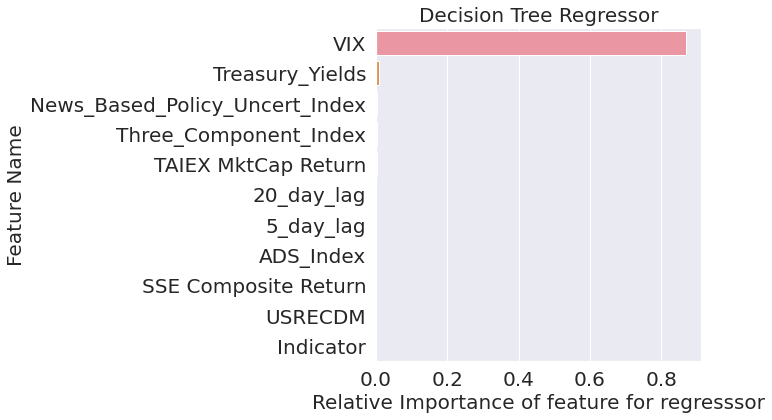

In [ ]:
compute_plot_feature_importance(model, title="Decision Tree Regressor")

0.09932367900066871
0.34106219639976076


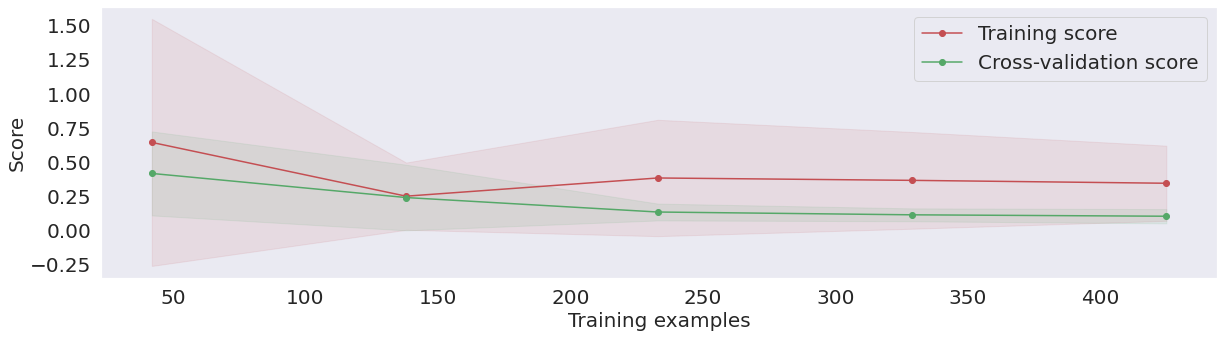

In [ ]:
plot_learning_curve(model.best_estimator_, X_train, y_train)

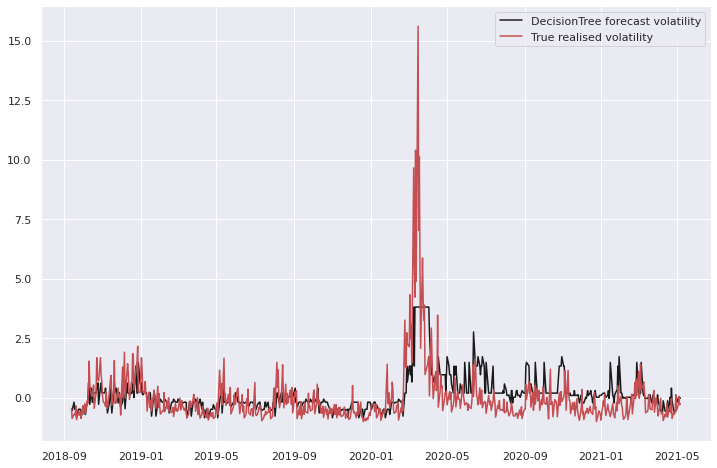

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_pred_test,label='DecisionTree forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

In [ ]:
# random forest

params = {"n_estimators": [10, 100, 250, 400],
          "criterion": ["mse", "mae"],
          "min_samples_split": [2, 5, 10],
          "max_depth": [int(x) for x in np.arange(3, 11)],
          "min_samples_leaf": [1, 2, 4]
          }

regressor = RandomForestRegressor(random_state=42)
model = RandomizedSearchCV(regressor, 
                           param_distributions = params, 
                           scoring = "r2",
                           n_iter = 2,
                           cv = btscv,
                           verbose = 1,
                           random_state = 42,
                           n_jobs = -1).fit(X_train, y_train)
print()
print("Best params:", model.best_params_)
print()

y_pred_train = model.best_estimator_.predict(X_train)
square_error_forest_train = (y_pred_train-y_train)**2
print('Train MSE for Random Forest Regressor =',square_error_forest_train.mean())

y_pred_test = model.best_estimator_.predict(X_test)
y_random=y_pred_test
square_error_forest_test = (y_pred_test-y_test)**2
print('Test MSE for Random Forest Regressor =',square_error_forest_test.mean())

aic_rtree = calculate_aic(len(y_pred_test), square_error_forest_test.mean(), num_params)
print('AIC for Random Forest Regressor: %.3f' % aic_rtree)

train_mae_rtree = mean_absolute_error(y_train, y_pred_train)
print('Train MAE for Random Forest Regressor: %.3f' % train_mae_rtree)

mae_rtree = mean_absolute_error(y_test, y_pred_test)
print('Test MAE for Random Forest Regressor: %.3f' % mae_rtree)

r2_rtree = r2_score(y_test, y_pred_test)
print('R_2 for Random Forest Regressor: %.3f' % r2_rtree)

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'criterion': 'mae'}

Train MSE for Random Forest Regressor = 0.11131084453959068
Test MSE for Random Forest Regressor = 0.8403426383086027
AIC for Random Forest Regressor: -99.848
Train MAE for Random Forest Regressor: 0.201
Test MAE for Random Forest Regressor: 0.517
R_2 for Random Forest Regressor: 0.492


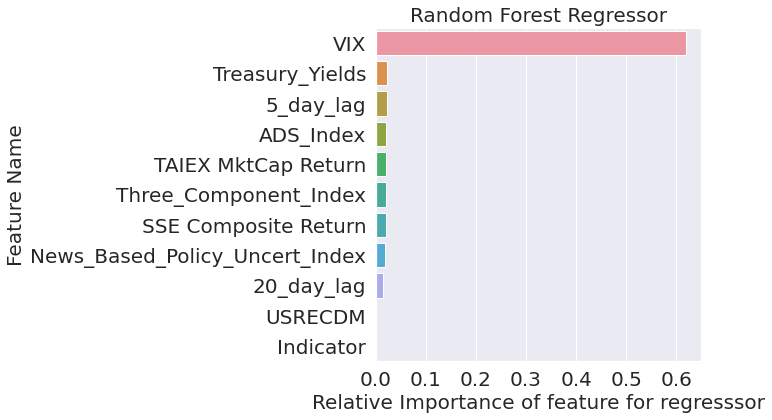

In [ ]:
compute_plot_feature_importance(model, title="Random Forest Regressor")

0.08860474437972274
0.06821490387295852


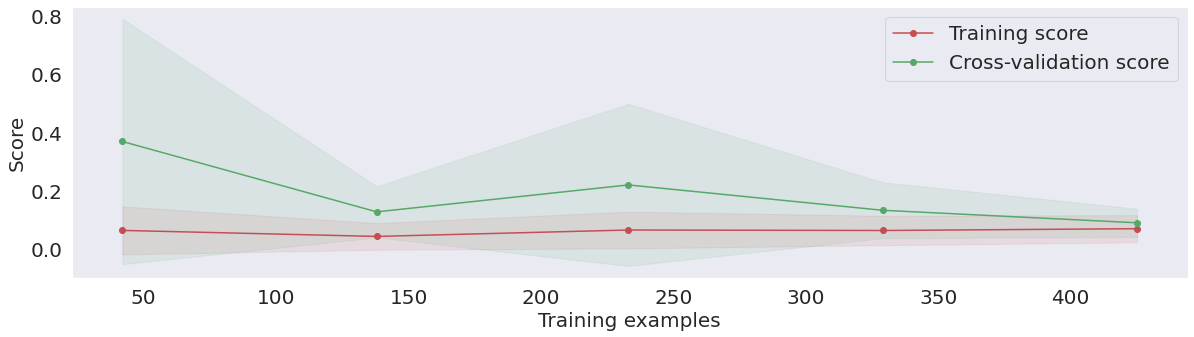

In [ ]:
plot_learning_curve(model.best_estimator_, X_train, y_train)

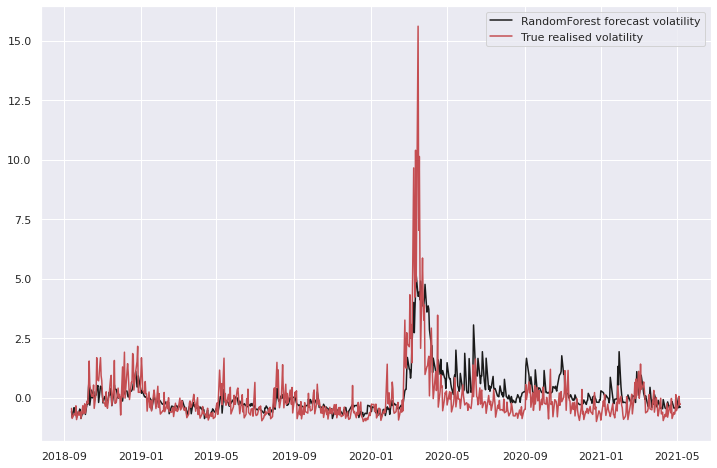

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,y_pred_test,label='RandomForest forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

# **ControlBurn**

In [ ]:
!pip install ControlBurn==0.0.9
!pip install mosek
!pip install cvxpy
from ControlBurn.ControlBurn import ControlBurnRegressor

In [ ]:
X_train.index.name = "index"
X_test.index.name = "index"
y_train.index = X_train.index
y_test.index = X_test.index

In [ ]:
cb = ControlBurnRegressor(build_forest_method = 'doublebagboost', alpha = 0.005)
cb.fit(X_train, y_train)

print('Number of trees grown: ' + str(len(cb.forest)))
print('Number of trees selected: ' + str(len(cb.subforest)))
print('Features selected ' + str(cb.features_selected_))

Number of trees grown: 28
Number of trees selected: 12
Features selected ['VIX']


In [ ]:
y_pred = cb.predict(X_train)
y_cb=y_pred
pred = cb.predict(X_test)
cb_train_mse = mean_squared_error(y_train,y_pred)
cb_train_mae = mean_absolute_error(y_train,y_pred)
cb_test_mse = mean_squared_error(y_test,pred)
cb_test_mae = mean_absolute_error(y_test,pred)
cb_test_r2 = r2_score(y_test,pred)
print('Train MSE of polished model: ' + str(cb_train_mse))
print('Train MAE of polished model: ' + str(cb_train_mae))
print('Test MSE of polished model: ' + str(cb_test_mse))
print('Test MAE of polished model: ' + str(cb_test_mae))
print('R_2 of polished model: ' + str(cb_test_r2))

Train MSE of polished model: 0.1177769214597555
Train MAE of polished model: 0.22367029070109387
Test MSE of polished model: 0.9606221277485958
Test MAE of polished model: 0.6091298056847957
R_2 of polished model: 0.41915151572121334


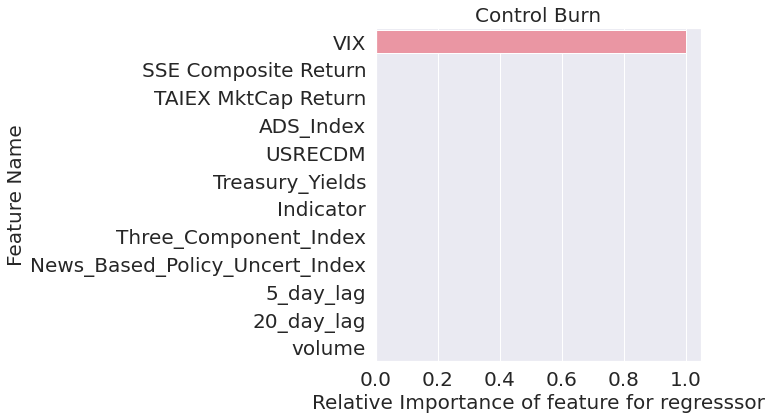

In [ ]:
compute_plot_feature_importance(cb, title="Control Burn")

In [ ]:
results = {'DecisionTreeRegressor':[square_error_tree_train.mean(), square_error_tree_test.mean(), train_mae_tree, mae_tree, aic_tree, r2_tree], 
           'RandomForestRegressor':[square_error_forest_train.mean(), square_error_forest_test.mean(), train_mae_rtree, mae_rtree, aic_rtree, r2_rtree],
           'ControlBurn':[cb_train_mse, cb_test_mse, cb_train_mae, cb_test_mae, "NaN", cb_test_r2]}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Train MSE","Test MSE","Train MAE","Test MAE","AIC","Test R_2 Score"]).T
results_df

,DecisionTreeRegressor,RandomForestRegressor,ControlBurn
Train MSE,0.210173,0.111311,0.117855
Test MSE,0.840692,0.840343,0.938067
Train MAE,0.267583,0.201427,0.223486
Test MAE,0.553111,0.517299,0.605394
AIC,-99.5708,-99.8477,NaN
Test R_2 Score,0.491668,0.49188,0.432789


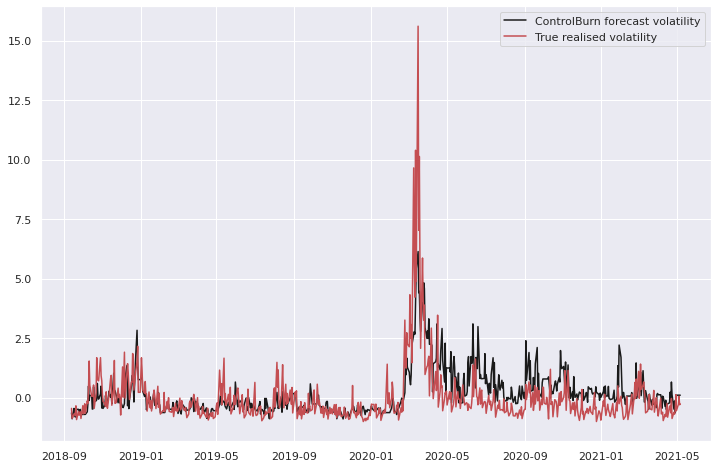

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(y_test.index,pred,label='ControlBurn forecast volatility',color='k')
plt.plot(y_test.index,y_test.values,label='True realised volatility',color='r')
plt.legend()
plt.show()

# **AutoML**

In [ ]:
%%capture
!pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
Xtrain = X_train.join(y_train)
test = X_test.join(y_test)
train = h2o.H2OFrame(Xtrain)
test = h2o.H2OFrame(test)

x = train.columns
y = "daily_vol"
x.remove(y)

aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgoxvdj3_
  JVM stdout: /tmp/tmpgoxvdj3_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgoxvdj3_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_unknownUser_spxcnw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:59:40.364: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_6_AutoML_1_20211203_165940

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.07093742435054337
RMSE: 0.26634080489204687
MAE: 0.16302507688786388
RMSLE: NaN
R^2: 0.9290359075053194
Mean Residual Deviance: 0.07093742435054337
Null degrees of freedom: 2660
Residual degrees o

In [ ]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_6_AutoML_1_20211203_165940,0.228939,0.478475,0.228939,0.274214,nan
StackedEnsemble_AllModels_2_AutoML_1_20211203_165940,0.229927,0.479507,0.229927,0.274319,nan
StackedEnsemble_BestOfFamily_3_AutoML_1_20211203_165940,0.23042,0.480021,0.23042,0.275196,nan
GBM_4_AutoML_1_20211203_165940,0.23151,0.481155,0.23151,0.276875,nan
StackedEnsemble_AllModels_5_AutoML_1_20211203_165940,0.232151,0.481821,0.232151,0.275287,nan
StackedEnsemble_AllModels_1_AutoML_1_20211203_165940,0.232585,0.482271,0.232585,0.275291,nan
GBM_2_AutoML_1_20211203_165940,0.233288,0.482999,0.233288,0.278545,nan
GBM_3_AutoML_1_20211203_165940,0.233665,0.483389,0.233665,0.275006,nan
StackedEnsemble_BestOfFamily_2_AutoML_1_20211203_165940,0.234285,0.48403,0.234285,0.276029,nan
StackedEnsemble_BestOfFamily_1_AutoML_1_20211203_165940,0.241681,0.491611,0.241681,0.287168,nan


In [ ]:
# %%capture
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.23.1
# !pip install lazypredict

# from lazypredict.Supervised import LazyRegressor, LazyClassifier

In [ ]:
# reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
# print(models)

# **GARCH**

In [ ]:
!pip install arch

Text(0, 0.5, 'Correlation of error terms with their lags')

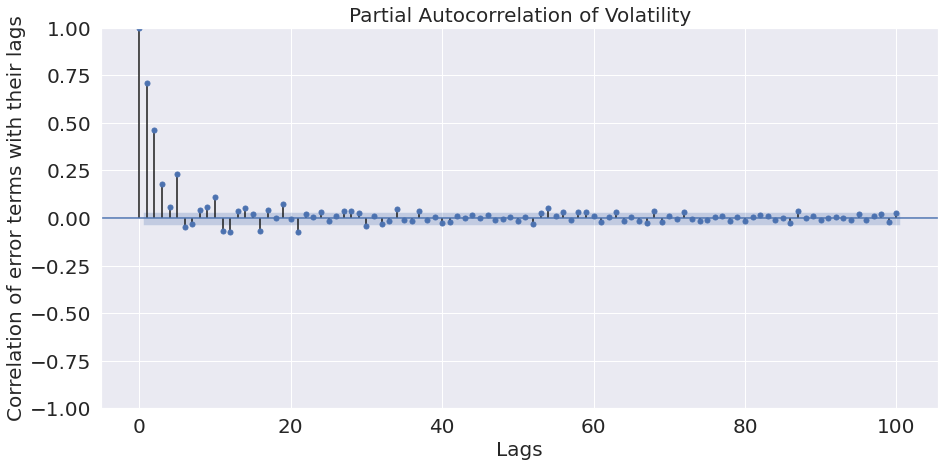

In [ ]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf

# From ACF model, the correlation is the most for lag = 2 so, p=2
# Finding q using PACF model
#Plotting pacf
N, M = 15, 7
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf((data['daily_vol']*1000).values,lags=100,ax=ax)
plt.title('Partial Autocorrelation of Volatility',fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.set_xlabel('Lags',fontsize=20)
ax.set_ylabel('Correlation of error terms with their lags',fontsize=20)

In [ ]:
q=1
#correlation between error terms and 1 lag error terms is the highest
dvol=data_org['daily_vol']*1000
n_test=int(.2*len(dvol))+1
dvol_train,dvol_test= dvol[:-n_test],dvol[-n_test:]

# define model
garch_model = arch_model(dvol_train, mean='Zero', vol='GARCH', p=2, q=1)
# fit model
garch_model_fit = garch_model.fit()
print(garch_model_fit.summary)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1388919290.804945
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1678.6998800154292
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1530.4235636152198
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1465.0244898835417
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1446.8649386130708
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1446.8399520484845
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1446.7604950464452
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1446.7603604263238
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1446.7603583812638
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1446.7603582903985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1446.7603583812638
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
<bound method ARCHModelResult.summary of                     

In [ ]:
# define model
garch_model = arch_model(dvol, mean='Zero', vol='GARCH', p=2, q=1)
# fit model
garch_model_fit = garch_model.fit()

i=dvol.index

start_loc = 0
end_loc = np.where(i >= "2018-09-13")[0].min()
forecasts = {}
for j in range(n_test):
    res = garch_model.fit(first_obs=j, last_obs=j + end_loc, disp="off")
    temp = res.forecast(horizon=3, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

forecasts=pd.DataFrame(forecasts).T
MSE_garch=(forecasts.iloc[:,0]-dvol_test)**2
print('MSE of GARCH (2,1)',MSE_garch.mean())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1750618355.2447422
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2096.5565877740564
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1931.37935858666
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1840.0707612255214
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1819.7292063339617
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1886.828637905207
Iteration:      7,   Func. Count:     42,   Neg. LLF: 2390.010525938791
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1819.4358221036237
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1819.4325545619704
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1819.4325419740076
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1819.4325412062963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1819.4325412062963
            Iterations: 11
            Function evaluations: 64
            Gradient evaluat

In [ ]:
data_org.head()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
Date,,,,,,,,,,,,
2008-02-20,0.000933,-0.020854,-0.016193,-1.11036,1.0,2.344,0.0,24.400000,108.104691,108.314735,0.000643,0.001293
2008-02-21,0.000638,-0.008725,0.024252,-1.11983,1.0,2.388,0.0,25.120001,108.104691,108.314735,0.000671,0.001896
2008-02-22,0.000387,-0.034656,0.002817,-1.12831,1.0,2.317,0.0,24.059999,108.104691,108.314735,0.000609,0.000898
2008-02-25,0.000716,-0.040673,0.021902,-1.14890,1.0,2.355,0.0,23.030001,108.104691,108.314735,0.000277,0.000544
2008-02-26,0.000581,0.010887,0.002578,-1.15557,1.0,2.268,0.0,21.900000,108.104691,108.314735,0.000768,0.000731


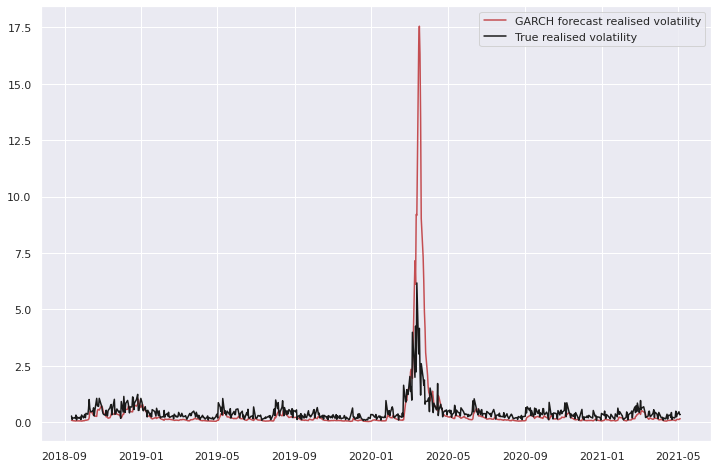

In [ ]:
#difference between true realised volatility vs volatility predicted by our model  and GARCH model
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(forecasts.index,forecasts[['h.1']],label='GARCH forecast realised volatility',color='r')
plt.plot(forecasts.index,dvol_test,label='True realised volatility',color='k')
plt.legend()
plt.show()


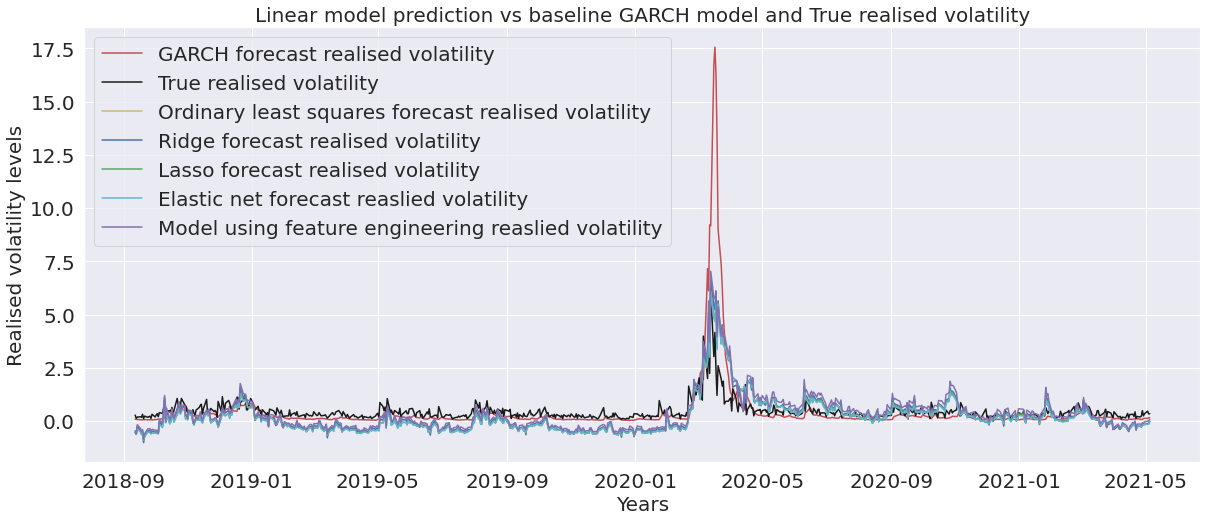

In [ ]:
#Linear model vs GARCH and true and true realised volatility
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(forecasts.index,forecasts[['h.1']],label='GARCH forecast realised volatility',color='r')
plt.plot(forecasts.index,dvol_test,label='True realised volatility',color='k')
plt.plot(forecasts.index,y_ols,label='Ordinary least squares forecast realised volatility',color='y')
plt.plot(forecasts.index,y_ridge,label='Ridge forecast realised volatility',color='b')
plt.plot(forecasts.index,y_lasso,label='Lasso forecast realised volatility',color='g')
plt.plot(forecasts.index,y_en,label='Elastic net forecast reaslied volatility',color='c')
plt.plot(forecasts.index,y_improved,label='Model using feature engineering reaslied volatility',color='m')
plt.title('Linear model prediction vs baseline GARCH model and True realised volatility',fontsize=20)
plt.ylabel('Realised volatility levels', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()


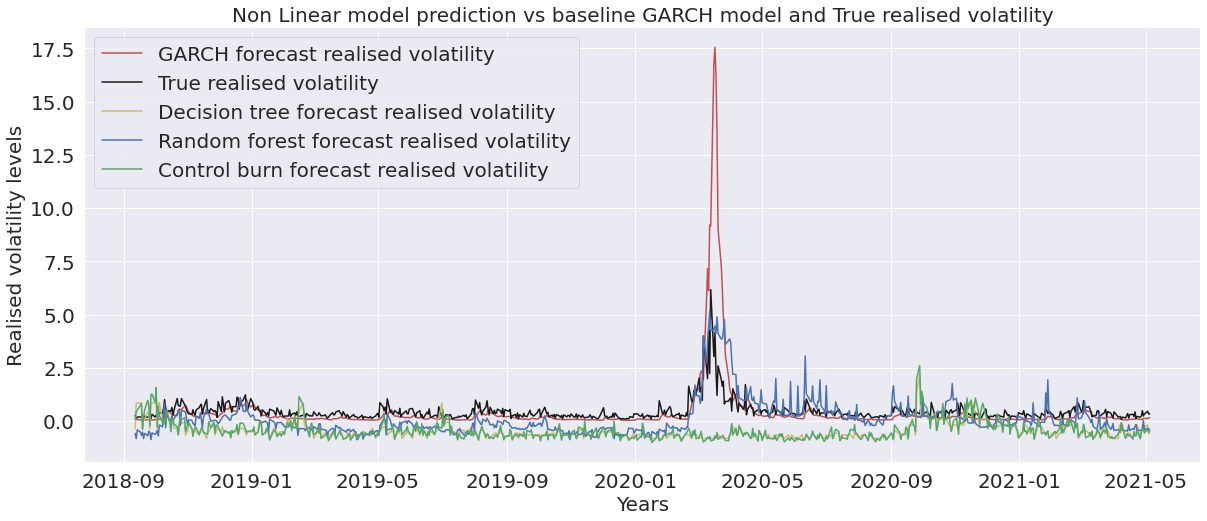

In [ ]:
#Non linear model vs GARCH and true realised volatility
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(forecasts.index,forecasts[['h.1']],label='GARCH forecast realised volatility',color='r')
plt.plot(forecasts.index,dvol_test,label='True realised volatility',color='k')
plt.plot(forecasts.index,y_decision[-666:],label='Decision tree forecast realised volatility',color='y')
plt.plot(forecasts.index,y_random[-666:],label='Random forest forecast realised volatility',color='b')
plt.plot(forecasts.index,y_cb[-666:],label='Control burn forecast realised volatility',color='g')
plt.title('Non Linear model prediction vs baseline GARCH model and True realised volatility',fontsize=20)
plt.ylabel('Realised volatility levels', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()